# Colour visualisation

In [6]:
%load_ext autoreload
%autoreload 2

# general
import numpy as np
import pandas as pd

# plotting
import matplotlib.pyplot as plt

# custom
from reflectance import spectrum_utils, file_ops, optimisation_pipeline, plotting

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Sentinel-vision

In [7]:
S2_response_fn_fp = file_ops.RESOURCES_DIR_FP / "satellite_response_functions" / "S2-SRF_COPE-GSEG-EOPG-TN-15-0007_3.2.xlsx"
response_fns_S2A = pd.read_excel(S2_response_fn_fp, sheet_name="Spectral Responses (S2A)", header=0, index_col=0)
response_fns_S2B = pd.read_excel(S2_response_fn_fp, sheet_name="Spectral Responses (S2B)", header=0, index_col=0)
# combine the two by averaging (minor technical differences between satellites in the same constellation)
S2_response_fns = pd.DataFrame(
        (response_fns_S2A.values + response_fns_S2B.values) / 2,
        index=response_fns_S2A.index,
        columns=response_fns_S2A.columns,
    )
S2_response_fns.head()

/Users/rt582/miniforge3/envs/spectra/lib/python3.12/site-packages/openpyxl/worksheet/_read_only.py:85: UserWarning: Unknown extension is not supported and will be removed
  for idx, row in parser.parse():
/Users/rt582/miniforge3/envs/spectra/lib/python3.12/site-packages/openpyxl/worksheet/_read_only.py:85: UserWarning: Unknown extension is not supported and will be removed
  for idx, row in parser.parse():


S2A_SR_AV_B1  S2A_SR_AV_B2  S2A_SR_AV_B3  S2A_SR_AV_B4  S2A_SR_AV_B5  \
SR_WL                                                                         
300             0.0           0.0           0.0           0.0           0.0   
301             0.0           0.0           0.0           0.0           0.0   
302             0.0           0.0           0.0           0.0           0.0   
303             0.0           0.0           0.0           0.0           0.0   
304             0.0           0.0           0.0           0.0           0.0   

       S2A_SR_AV_B6  S2A_SR_AV_B7  S2A_SR_AV_B8  S2A_SR_AV_B8A  S2A_SR_AV_B9  \
SR_WL                                                                          
300             0.0           0.0           0.0            0.0           0.0   
301             0.0           0.0           0.0            0.0           0.0   
302             0.0           0.0           0.0            0.0           0.0   
303             0.0           0.0           0.0            0.0           0.0   
304             0.0           0.0           0.0            0.0           0.0   

       S2A_SR_AV_B10  S2A_SR_AV_B11  S2A_SR_AV_B12  
SR_WL                                               
300              0.0            0.0            0.0  
301              0.0            0.0            0.0  
302              0.0            0.0            0.0  
303              0.0            0.0            0.0  
304              0.0            0.0            0.0

In [8]:
prism_spectra = spectrum_utils.load_spectra()
emulated_S2_df = spectrum_utils.visualise_satellite_from_prism(prism_spectra, S2_response_fns, bois=["B2", "B3", "B4", "B8A"])   # S2

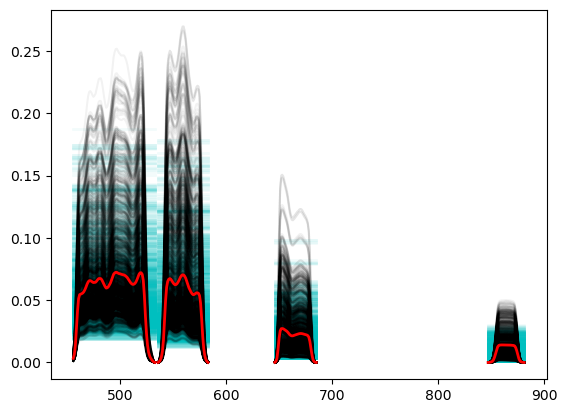

In [9]:
interped_prism = spectrum_utils.interp_df(prism_spectra)
S2_band_vals_df = spectrum_utils.calculate_band_values(S2_response_fns, bois=["B2", "B3", "B4", "B8A"], interped_prism=interped_prism)
S2_continuous_response_df = interped_prism * S2_band_vals_df
S2_mean_response_df = S2_continuous_response_df.mean(axis=0, skipna=True)
S2_flattened_mean_response_df = spectrum_utils.fill_clumps_with_mean(S2_continuous_response_df)

lim_bands = S2_response_fns.index[(S2_response_fns.index >= min(prism_spectra.columns)) & (S2_response_fns.index <= max(prism_spectra.columns))]
plt.plot(lim_bands, S2_continuous_response_df.T, alpha=0.05, color="k");
plt.plot(lim_bands, S2_mean_response_df, color="r", linewidth=2);
plt.plot(lim_bands, S2_flattened_mean_response_df.T, alpha=0.05, color="c", linewidth=2, zorder=-1);

Text(0, 0.5, 'Reflectance')

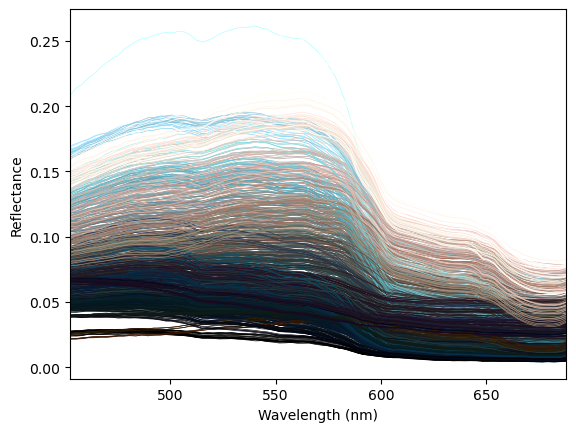

In [10]:
s2_rgbs = plotting.visualise_spectral_colours(emulated_S2_df.values, [2,98])

N_spectra = 1000
fig, ax = plt.subplots()
cropped_prism = spectrum_utils.crop_spectra_to_range(prism_spectra, spectrum_utils.SENSOR_RANGE)
for r, row in cropped_prism.iloc[:N_spectra,:].iterrows():
    ax.plot(row, c=s2_rgbs[r,:], lw=0.5)
ax.set_xlim(min(cropped_prism.columns), max(cropped_prism.columns))
ax.set_xlabel("Wavelength (nm)")
ax.set_ylabel("Reflectance")

## PLANET DOVE Vision

In [11]:
# load response functions
planet_response_fns_fp = file_ops.RESOURCES_DIR_FP / "satellite_response_functions" / "dove_r.csv"
planet_response_fns = pd.read_csv(planet_response_fns_fp, index_col=0)
planet_response_fns.head()

Blue  Green  Red  NIR
Wavelength (nm)                       
400               0.0    0.0  0.0  0.0
401               0.0    0.0  0.0  0.0
402               0.0    0.0  0.0  0.0
403               0.0    0.0  0.0  0.0
404               0.0    0.0  0.0  0.0

In [12]:
# planet has loads of small values in between the main peaks: for now, casting to nan
planet_response_fns[planet_response_fns < 0.01] = np.nan

emulated_planet_df = spectrum_utils.visualise_satellite_from_prism(prism_spectra, planet_response_fns, bois=["Blue", "Green", "Red", "NIR"])   # planet
emulated_planet_df.head()

B2        B3        B4
0  0.035377  0.112722  0.109926
1  0.035540  0.112711  0.109368
2  0.032450  0.102784  0.100149
3  0.035029  0.113642  0.110784
4  0.036526  0.115683  0.111724

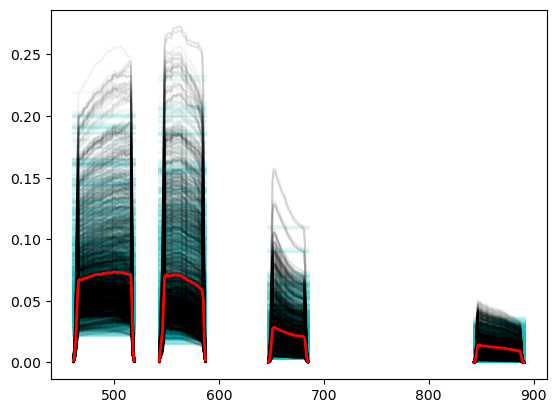

In [13]:
planet_band_vals_df = spectrum_utils.calculate_band_values(planet_response_fns, bois=["Blue", "Green", "Red", "NIR"], interped_prism=interped_prism)
planet_continuous_response_df = interped_prism.loc[:, planet_band_vals_df.index] * planet_band_vals_df
planet_mean_response_df = planet_continuous_response_df.mean(axis=0, skipna=True)
planet_flattened_mean_response_df = spectrum_utils.fill_clumps_with_mean(planet_continuous_response_df)

planet_lim_bands = planet_response_fns.index.intersection(interped_prism.columns)
plt.plot(planet_lim_bands, planet_continuous_response_df.T, alpha=0.05, color="k");
plt.plot(planet_lim_bands, planet_mean_response_df, color="r", linewidth=2);
plt.plot(planet_lim_bands, planet_flattened_mean_response_df.T, alpha=0.05, color="c", linewidth=2, zorder=-1);

Text(0, 0.5, 'Reflectance')

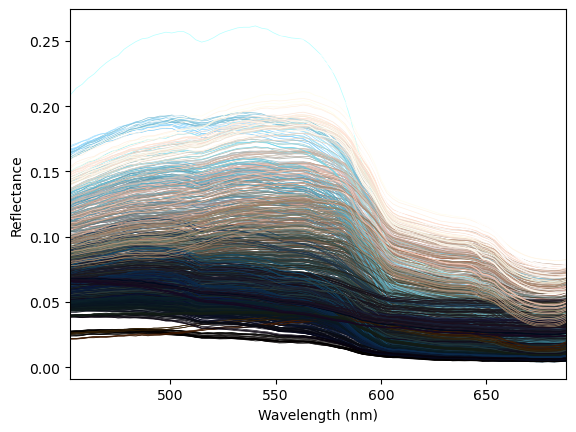

In [14]:
planet_rgbs = plotting.visualise_spectral_colours(emulated_planet_df.values, [2,98])

N_spectra = 1000
fig, ax = plt.subplots()
cropped_prism = spectrum_utils.crop_spectra_to_range(prism_spectra, spectrum_utils.SENSOR_RANGE)
for r, row in cropped_prism.iloc[:N_spectra,:].iterrows():
    ax.plot(row, c=planet_rgbs[r,:], lw=0.5)
ax.set_xlim(min(cropped_prism.columns), max(cropped_prism.columns))
ax.set_xlabel("Wavelength (nm)")
ax.set_ylabel("Reflectance")

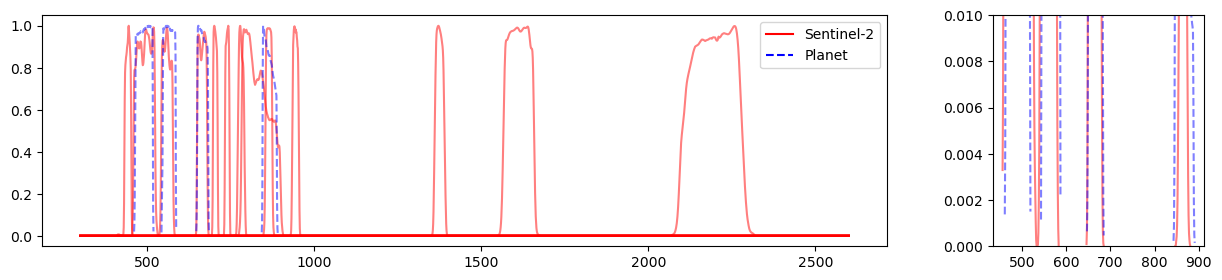

In [15]:
# comparing S2 and Planet response functions
fig, axs = plt.subplots(1,2, figsize=(15,3), width_ratios=[4,1])
axs[0].plot(S2_response_fns, ls="-", alpha=0.5,c="r")
axs[0].plot(planet_response_fns, ls="--", alpha=0.5,c="b")
axs[0].plot([],[],ls="-",label="Sentinel-2",c="r")
axs[0].plot([],[],ls="--",label="Planet",c="b")

axs[1].plot(S2_continuous_response_df.mean(axis=0), ls="-", alpha=0.5, c="r")
axs[1].plot(planet_continuous_response_df.mean(axis=0), ls="--", alpha=0.5, c="b")
axs[1].set_ylim(0,0.01)
axs[0].legend();

# Visualising colours of spectra

In [16]:
glob_cfg, _ = file_ops.instantiate_single_configs_instance(run_ind = 0)
AOP_model = spectrum_utils.load_aop_model(aop_group_num=1)
AOP_args = (
    AOP_model.bb_m.values,
    AOP_model.bb_c.values,
    AOP_model.Kd_m.values,
    AOP_model.Kd_c.values,
)
wvs = AOP_model.index

endmember_class_schema = "three_endmember"
endmember_array = optimisation_pipeline.GenerateEndmembers(
    endmember_class_map = glob_cfg.endmember_schema[endmember_class_schema],
    endmember_dimensionality_reduction = "mean"
    ).generate_endmembers()

endmember_cats = endmember_array.index

In [17]:
algae_sim_spectra, metadata = spectrum_utils.simulate_spectra(endmember_array, wvs, AOP_args, (1, 0, 0), N=1)  # Rb values: algae, coral, sand
coral_sim_spectra, metadata = spectrum_utils.simulate_spectra(endmember_array, wvs, AOP_args, (0, 1, 0), N=1)  # Rb values: algae, coral, sand
sand_sim_spectra, metadata = spectrum_utils.simulate_spectra(endmember_array, wvs, AOP_args, (0, 0, 1), N=1)  # Rb values: algae, coral, sand

all_spectra = np.concatenate([algae_sim_spectra, coral_sim_spectra, sand_sim_spectra], axis=0)
flattened_sim_spectra = all_spectra.reshape(-1, all_spectra.shape[-1])

Generating simulated spectra:   0%|          | 0/10000 [00:00<?, ?it/s]

Generating simulated spectra:   0%|          | 0/10000 [00:00<?, ?it/s]

Generating simulated spectra:   0%|          | 0/10000 [00:00<?, ?it/s]

In [18]:
spectra_df = pd.DataFrame(flattened_sim_spectra, columns = wvs)
norm_rgb_values = plotting.generate_spectra_color(spectra_df)

In [19]:
norm_rgb_values

array([[0.05118234, 0.06335918, 0.03900591],
       [0.05170177, 0.06415106, 0.03865928],
       [0.05141195, 0.06376694, 0.03866363],
       ...,
       [0.00685359, 0.0443985 , 0.05003755],
       [0.00675688, 0.04448161, 0.05008274],
       [0.00675975, 0.04440669, 0.05008229]])

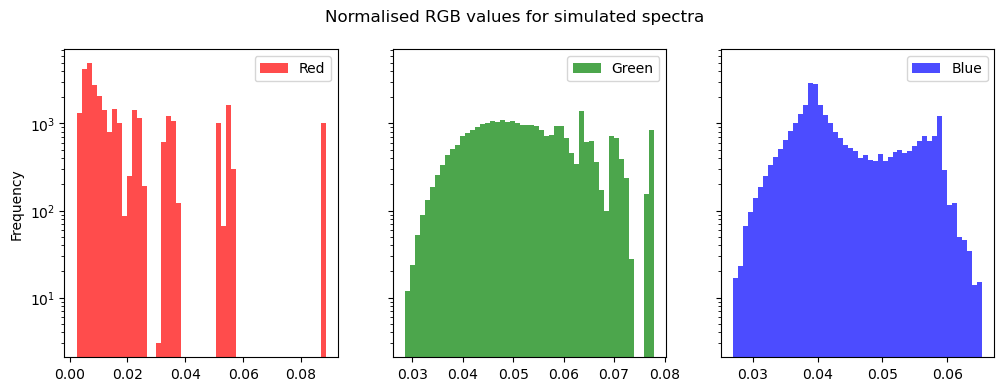

In [20]:
# plot histogram of red, green, and blue values
fig, axs = plt.subplots(1, 3, figsize=(12, 4), sharey=True)

norm_reds = norm_rgb_values[:, 0]
norm_greens = norm_rgb_values[:, 1]
norm_blues = norm_rgb_values[:, 2]

plt.suptitle("Normalised RGB values for simulated spectra")
for i, (ax, rgb, colour) in enumerate(zip(axs, [norm_reds, norm_greens, norm_blues], ["Red", "Green", "Blue"])):
    ax.hist(rgb, bins=50, color=colour, alpha=0.7, label=colour)
    ax.set_yscale('log')
    ax.legend()
axs[0].set_ylabel("Frequency");

Plotting algae spectra:   0%|          | 0/1000 [00:00<?, ?it/s]

Plotting coral spectra:   0%|          | 0/1000 [00:00<?, ?it/s]

Plotting sand spectra:   0%|          | 0/1000 [00:00<?, ?it/s]

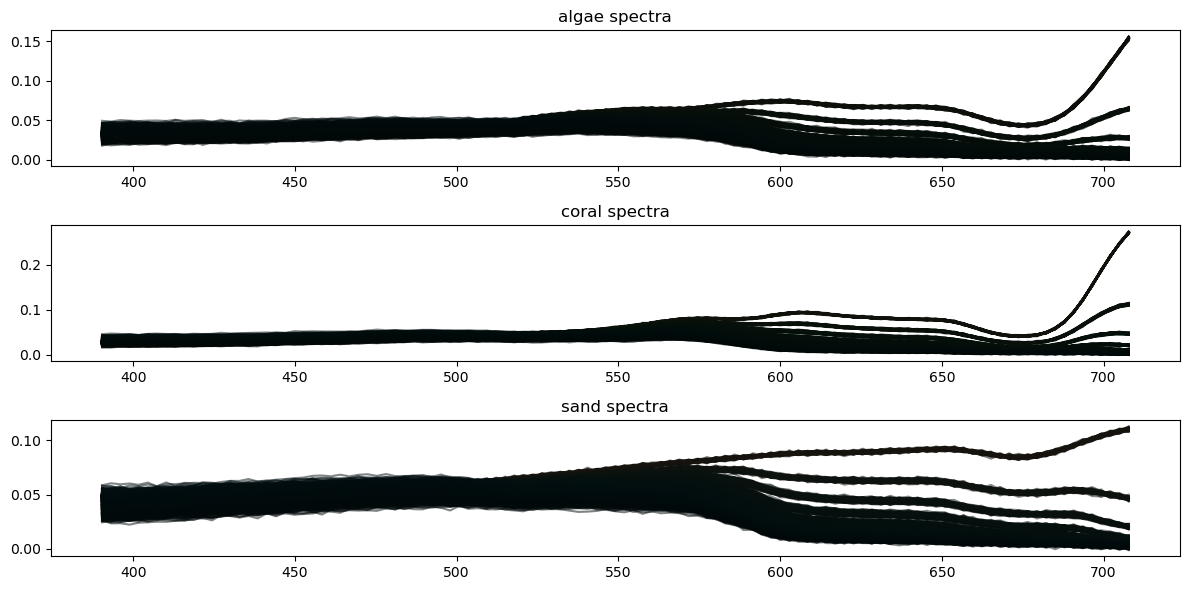

In [21]:
# plot spectra in RGB space
subset_interval = 10

from tqdm.auto import tqdm

fig, axes = plt.subplots(nrows=3, figsize=(12, 6))

for s, (spectra, spectra_title) in enumerate(zip([algae_sim_spectra, coral_sim_spectra, sand_sim_spectra], ["algae", "coral", "sand"])):
    # flatten spectrum
    flat_spectra = spectra.values.reshape(-1, 113)
    # select subset
    lim_spectra = flat_spectra[::subset_interval]
    
    for i, spectrum in tqdm(enumerate(lim_spectra), total=len(lim_spectra), desc=f"Plotting {spectra_title} spectra"):
        axes[s].plot(wvs, spectrum, color=norm_rgb_values[len(flat_spectra)*s:(s+1)*len(flat_spectra)][::subset_interval][i], alpha=0.5)
        
    axes[s].set_title(f"{list(endmember_cats)[s]} spectra")
        
plt.tight_layout()

# AOP model visualisations

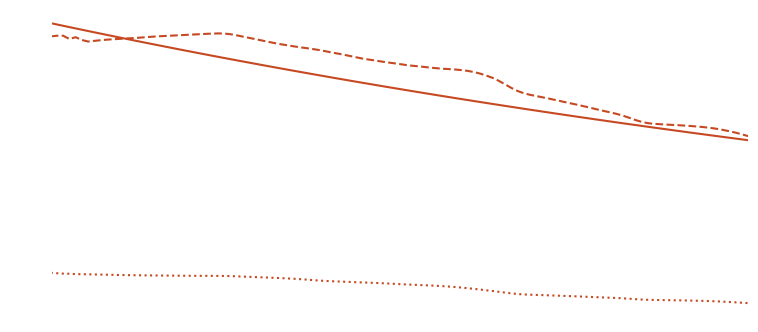

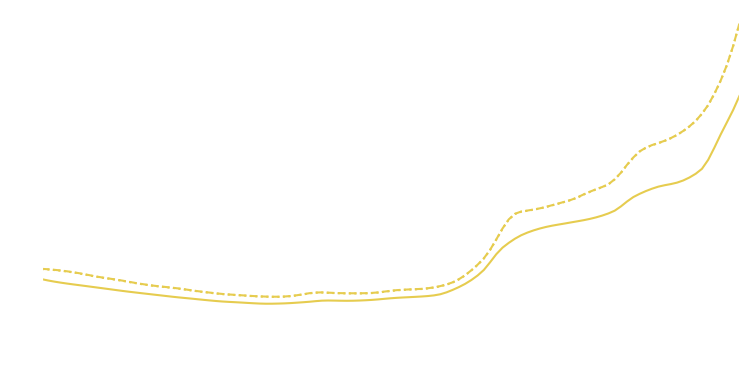

In [22]:
AOP_model = spectrum_utils.load_aop_model(aop_group_num=1)
red_hex = "#C64922"
yellow_hex = "#E6CC4F"
styles = ['-', '-', '--', ':']
    
# compare AOP models    
bb_f, bb_axes = plt.subplots(1, 1, figsize=(9, 4))
K_f, K_axes = plt.subplots(1, 1, figsize=(9, 4))

for aop_group_num in range(1, 4):
    AOP_model = spectrum_utils.load_aop_model(aop_group_num=aop_group_num)
    wvs = AOP_model.index

    K_axes.plot(wvs, AOP_model.loc[wvs].Kd_m + AOP_model.loc[wvs].Kd_c, ls=styles[aop_group_num], color=yellow_hex, label=f"Group {aop_group_num}", alpha=1)
    bb_axes.plot(wvs, AOP_model.loc[wvs].bb_m + AOP_model.loc[wvs].bb_c, ls=styles[aop_group_num], color=red_hex, label=f"Group {aop_group_num}", alpha=1)

for ax in (bb_axes, K_axes):
    # ax.patch.set_alpha(0)
    ax.set_xlim(min(wvs), max(wvs))
    # set outside ticks and lines to be white
    [ax.spines[pos].set_color('white') for pos in ax.spines.keys()]
    # set ticks to be white
    ax.tick_params(axis='x', colors='white')
    ax.tick_params(axis='y', colors='white')
    ax.grid(True, color='white', ls='--', linewidth=0.5, alpha=0.5, which='both')
    
# remove numbers from bb_axes x axis
bb_axes.set_xticklabels([])
K_axes.set_xlabel("Wavelength (nm)", color="white")

# save figs
bb_f.savefig(file_ops.RESULTS_DIR_FP / "figures/bb_models.png", dpi=300, transparent=True)
K_f.savefig(file_ops.RESULTS_DIR_FP / "figures/K_models.png", dpi=300, transparent=True)

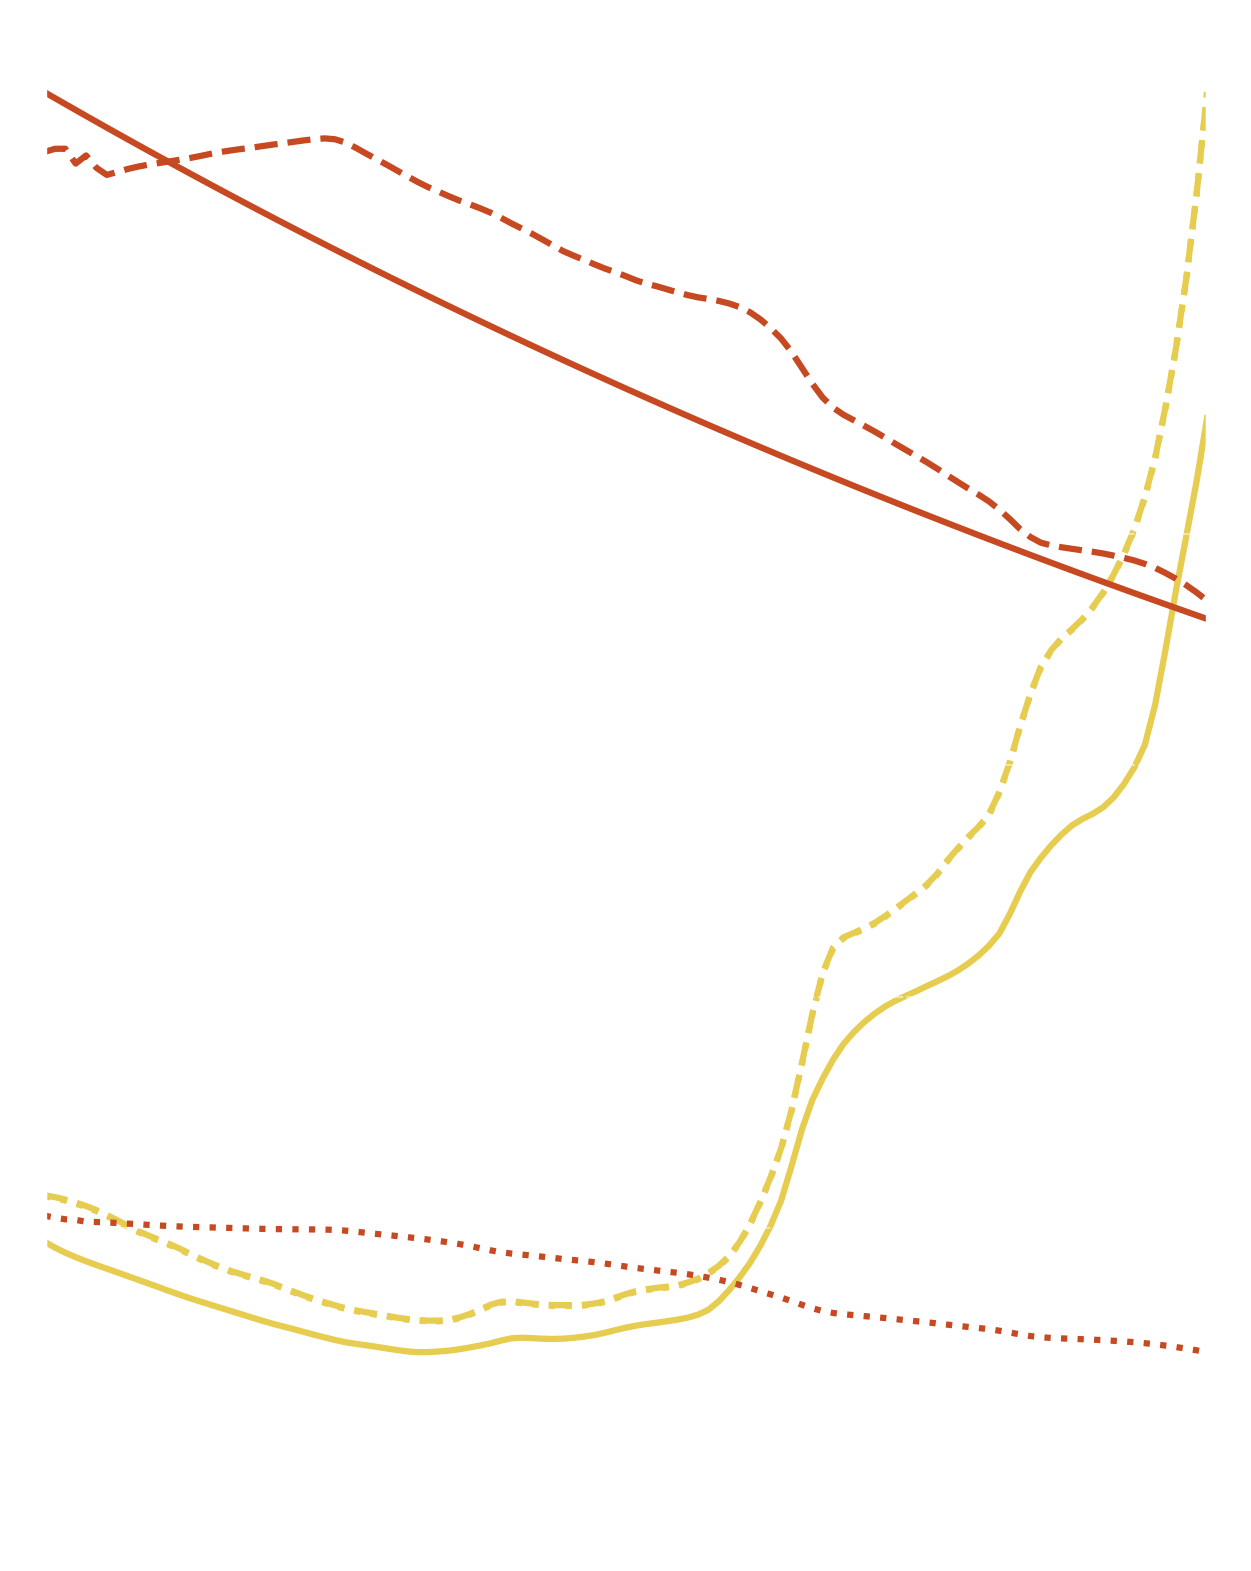

In [23]:
# plot bb and K on same figure
fig, K_ax = plt.subplots(1, 1, figsize=(5, 6), dpi=300)

bb_ax = K_ax.twinx()

for aop_group_num in range(1, 4):
    AOP_model = spectrum_utils.load_aop_model(aop_group_num=aop_group_num)
    wvs = AOP_model.index

    K_ax.plot(wvs, AOP_model.loc[wvs].Kd_m + AOP_model.loc[wvs].Kd_c, ls=styles[aop_group_num], color=yellow_hex, label=f"Group {aop_group_num}", alpha=1)
    bb_ax.plot(wvs, AOP_model.loc[wvs].bb_m + AOP_model.loc[wvs].bb_c, ls=styles[aop_group_num], color=red_hex, label=f"Group {aop_group_num}", alpha=1)

for ax in [K_ax, bb_ax]:
    ax.patch.set_alpha(0)
    ax.set_xlim(min(wvs), max(wvs))
    ax.set_xlabel("Wavelength (nm)", color="white")
    ax.set_yticklabels([])
    plotting.format_axis_for_ppt(ax)
ax.grid(True, color='white', ls='--', linewidth=0.5, alpha=0.5, which='both')
fig.patch.set_alpha(0)

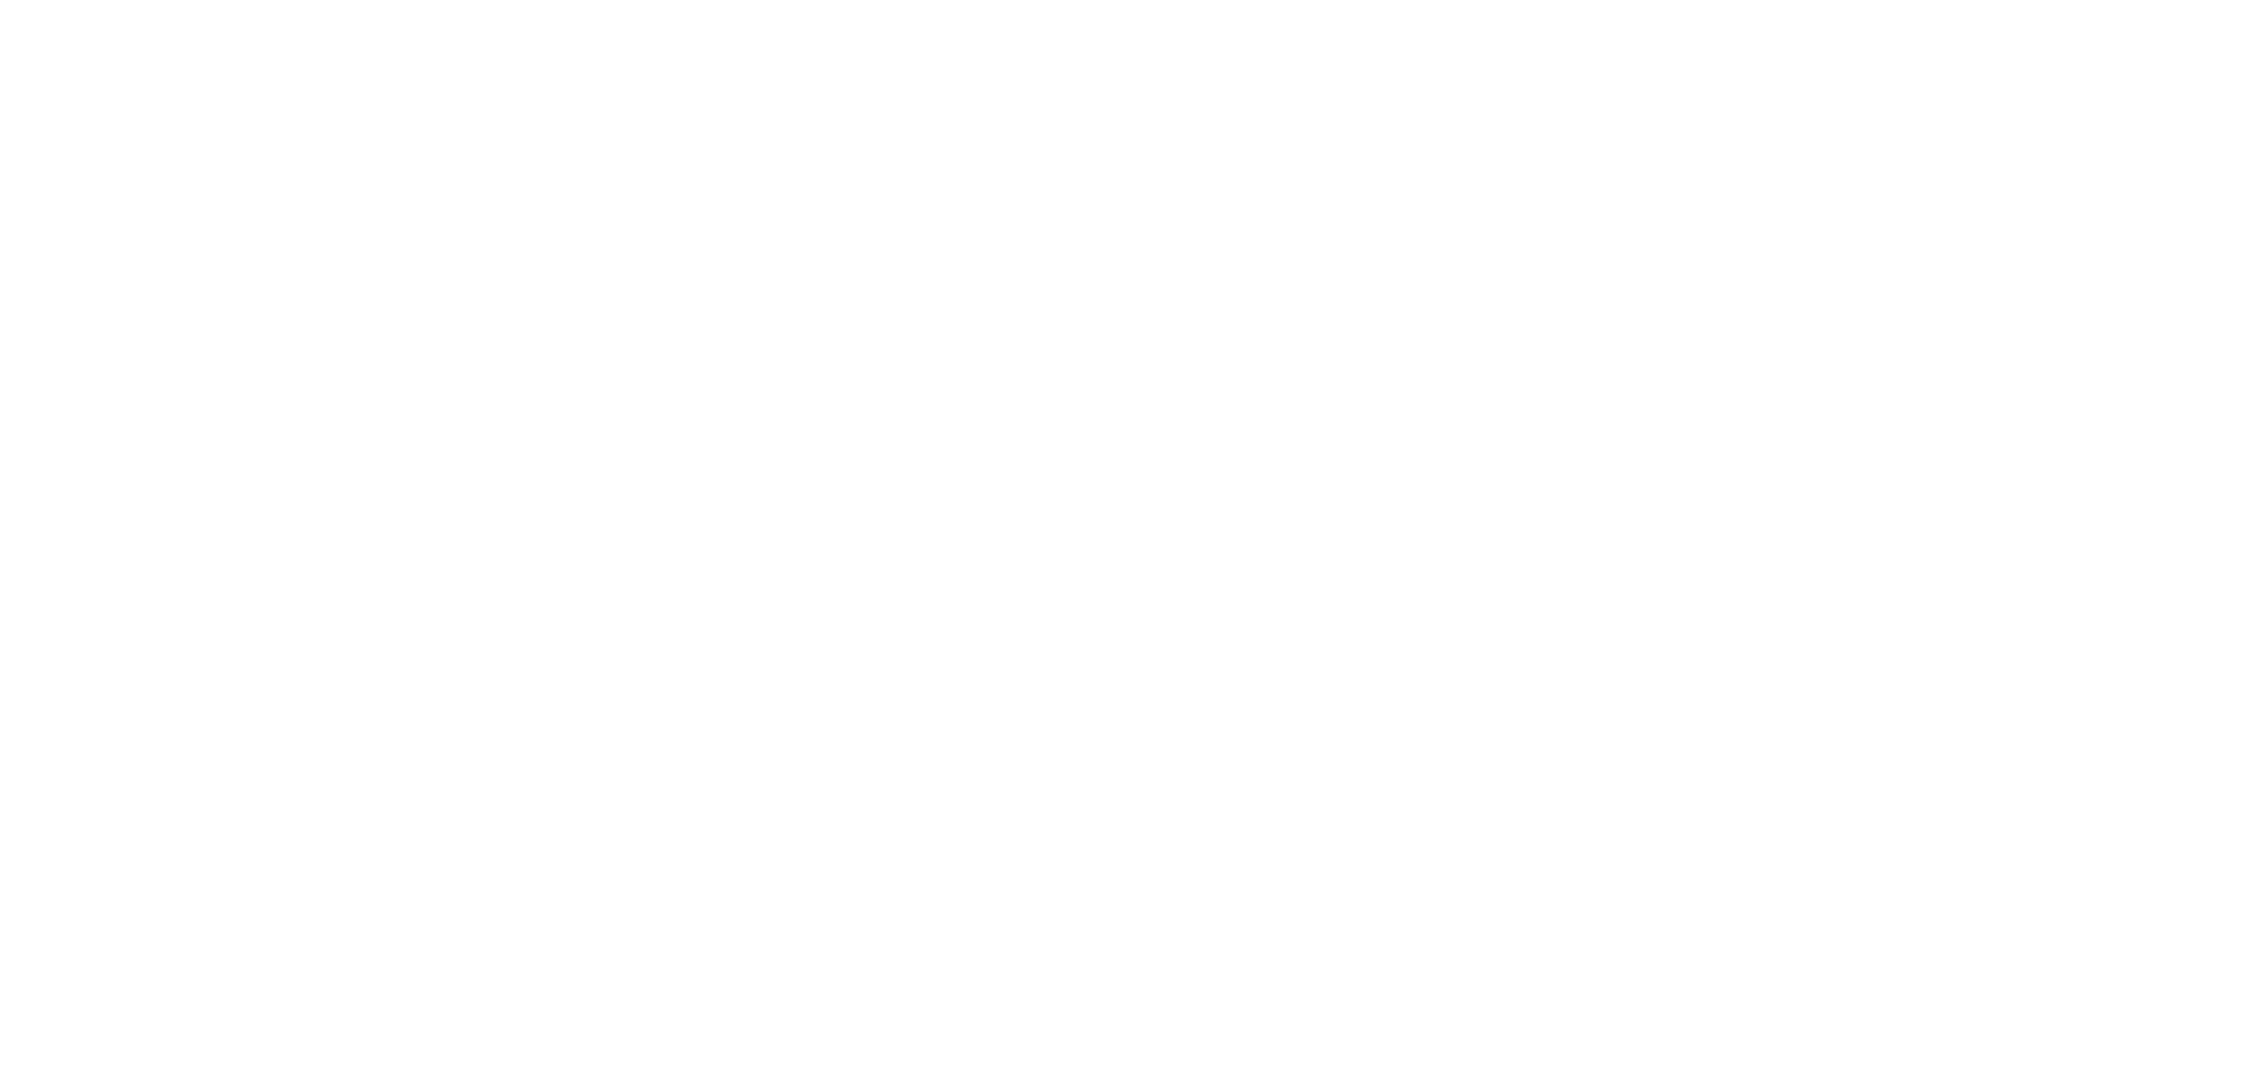

In [24]:
from matplotlib.animation import FuncAnimation, FFMpegWriter, ImageMagickWriter

def update_K(frame):
    K_axes.cla()
    K_axes.patch.set_alpha(0)
    K_f.patch.set_alpha(0)
    for aop_group_num in range(1, 4):
        AOP_model = spectrum_utils.load_aop_model(aop_group_num=aop_group_num)
        wvs = AOP_model.index

        K_axes.plot(wvs[:frame], (AOP_model.loc[wvs[:frame]].Kd_m + AOP_model.loc[wvs[:frame]].Kd_c), ls=styles[aop_group_num], color=yellow_hex, label=f"Group {aop_group_num}", alpha=1)
    
    # Set up the axes
    K_axes.set_xlim(min(AOP_model.index), max(AOP_model.index))
    plotting.format_axis_for_ppt(K_axes)
    K_axes.set_xticklabels([])
    K_axes.grid(True, color='white', ls='--', linewidth=0.5, alpha=0.5, which='both')
    K_axes.set_xlabel("Wavelength (nm)", color="white")
    return K_axes

# Create the figures and axes
K_f, K_axes = plt.subplots(1, 1, figsize=(9, 4), dpi=300)

# Create the animation
ani_bb = FuncAnimation(K_f, update_K, frames=len(AOP_model.index), blit=False, repeat=False, interval=60, repeat_delay=1000)

writer = FFMpegWriter(fps=30, metadata={'loop': 0}, extra_args=['-loop', '1'])
ani_bb.save(file_ops.RESULTS_DIR_FP / "figures/K_models_animation.gif", writer=writer, savefig_kwargs={'transparent': True}, dpi=200)

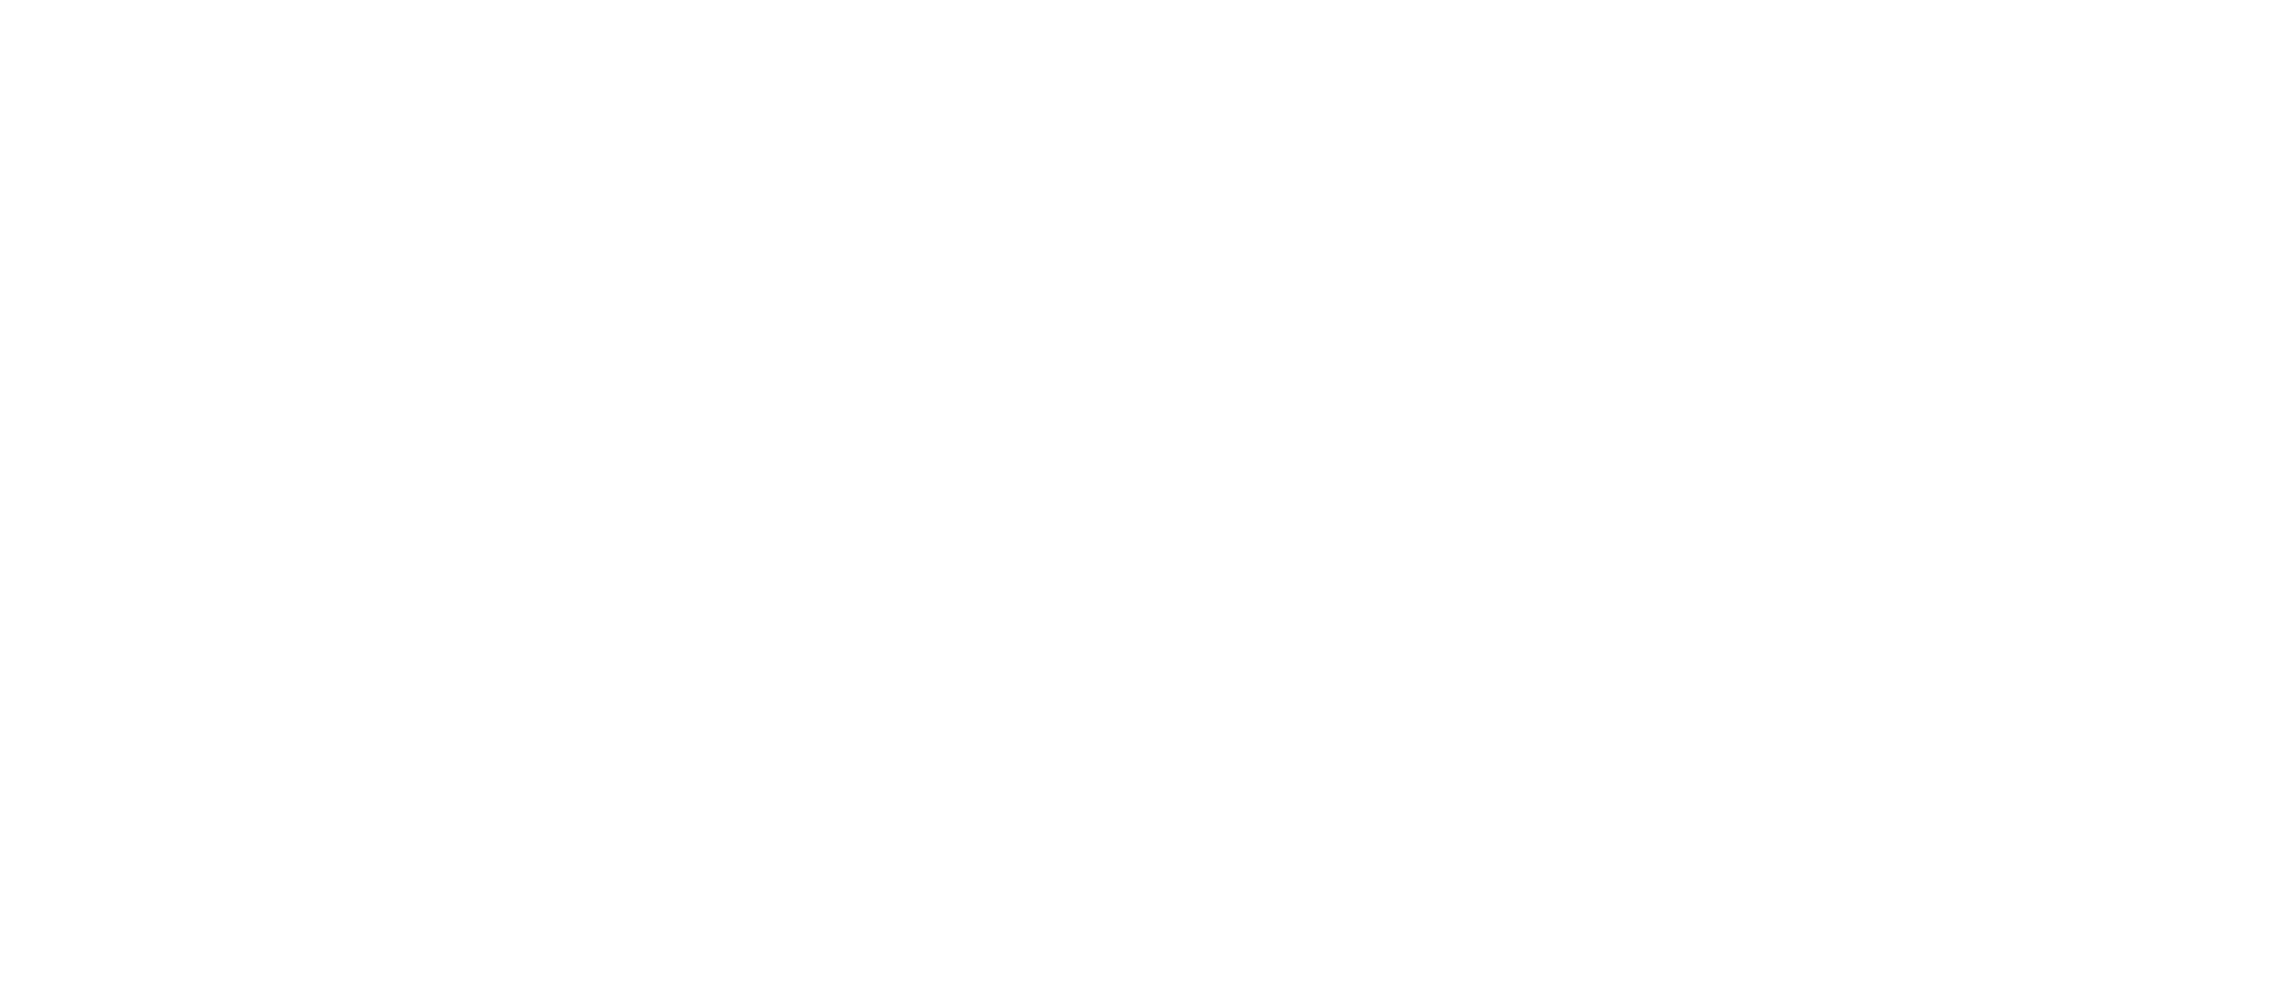

In [25]:
from matplotlib.animation import FuncAnimation, FFMpegWriter, ImageMagickWriter

def update_bb(frame):
    bb_axes.cla()
    bb_axes.patch.set_alpha(0)
    bb_f.patch.set_alpha(0)
    for aop_group_num in range(1, 4):
        AOP_model = spectrum_utils.load_aop_model(aop_group_num=aop_group_num)
        wvs = AOP_model.index

        bb_axes.plot(wvs[:frame], (AOP_model.loc[wvs[:frame]].bb_m + AOP_model.loc[wvs[:frame]].bb_c), ls=styles[aop_group_num], color=red_hex, label=f"Group {aop_group_num}", alpha=1)
    
    # Set up the axes
    bb_axes.set_xlim(min(AOP_model.index), max(AOP_model.index))
    plotting.format_axis_for_ppt(bb_axes)
    bb_axes.set_xticklabels([])
    bb_axes.grid(True, color='white', ls='--', linewidth=0.5, alpha=0.5, which='both')

    return bb_axes

# Create the figures and axes
bb_f, bb_axes = plt.subplots(1, 1, figsize=(9, 4), dpi=300)

# Create the animation
ani_bb = FuncAnimation(bb_f, update_bb, frames=len(AOP_model.index), blit=False, repeat=False, interval=60, repeat_delay=1000)


writer = FFMpegWriter(fps=30, metadata={'loop': 0}, extra_args=['-loop', '1'])
ani_bb.save(file_ops.RESULTS_DIR_FP / "figures/bb_models_animation.mp4", writer=writer, savefig_kwargs={'transparent': True}, dpi=200)

# Validation spectra

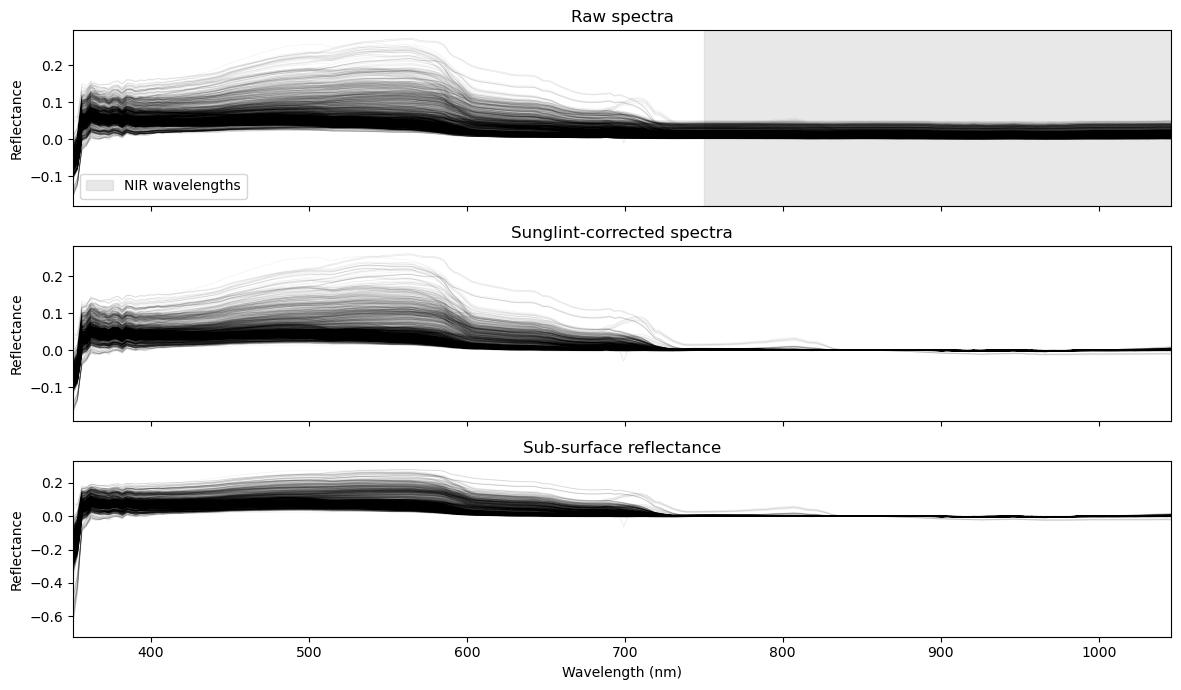

In [26]:
# benthic counts data
validation_data = pd.read_csv(file_ops.DATA_DIR_FP / "CORAL_validation_data.csv")
# spectral data (PRISM-measured reflectance from nearby pixels)
spectra_raw = pd.read_csv(file_ops.DATA_DIR_FP / "CORAL_validation_spectra.csv")
spectra_raw.columns = spectra_raw.columns.astype(float)


fig, ax = plt.subplots(3, 1, figsize=(12, 7), sharex=True)

NIR_wvs = (750, 1100)
SENSOR_LIMS = (450, 690)

ax[0].plot(spectra_raw.columns, spectra_raw.values.T, color=(0,0,0,0.05), lw=0.5);
# shade NIR waveband: (https://www.lidsen.com/journals/aeer/aeer-02-03-017)
ax[0].axvspan(min(NIR_wvs), max(spectra_raw.columns) if max(spectra_raw.columns) < max(NIR_wvs) else max(spectra_raw.columns), color='lightgrey', alpha=0.5, zorder=-2, label="NIR wavelengths")
ax[0].set_title("Raw spectra")
ax[0].legend()

# sun glint correction - subtract values between 750 and 1100 (NIR) from rest of data
spectra_deglinted = spectrum_utils.deglint_spectra(spectra_raw, NIR_wvs)

# calculate sub-surface reflectance (from Lee et al. 1998)
spectra_corrected = spectrum_utils.retrieve_subsurface_reflectance(spectra_deglinted)

ax[1].plot(spectra_deglinted.columns, spectra_deglinted.values.T, color=(0,0,0,0.05), lw=0.5);
ax[1].set_title("Sunglint-corrected spectra")

# plot corrected spectra
ax[2].plot(spectra_corrected.columns, spectra_corrected.values.T, color=(0,0,0,0.05), lw=0.5);
ax[2].set_title("Sub-surface reflectance")

for a in ax:
    a.set_xlim(spectra_corrected.columns.min(), spectra_corrected.columns.max())
    a.set_ylabel("Reflectance")
ax[2].set_xlabel("Wavelength (nm)")
    
plt.tight_layout()

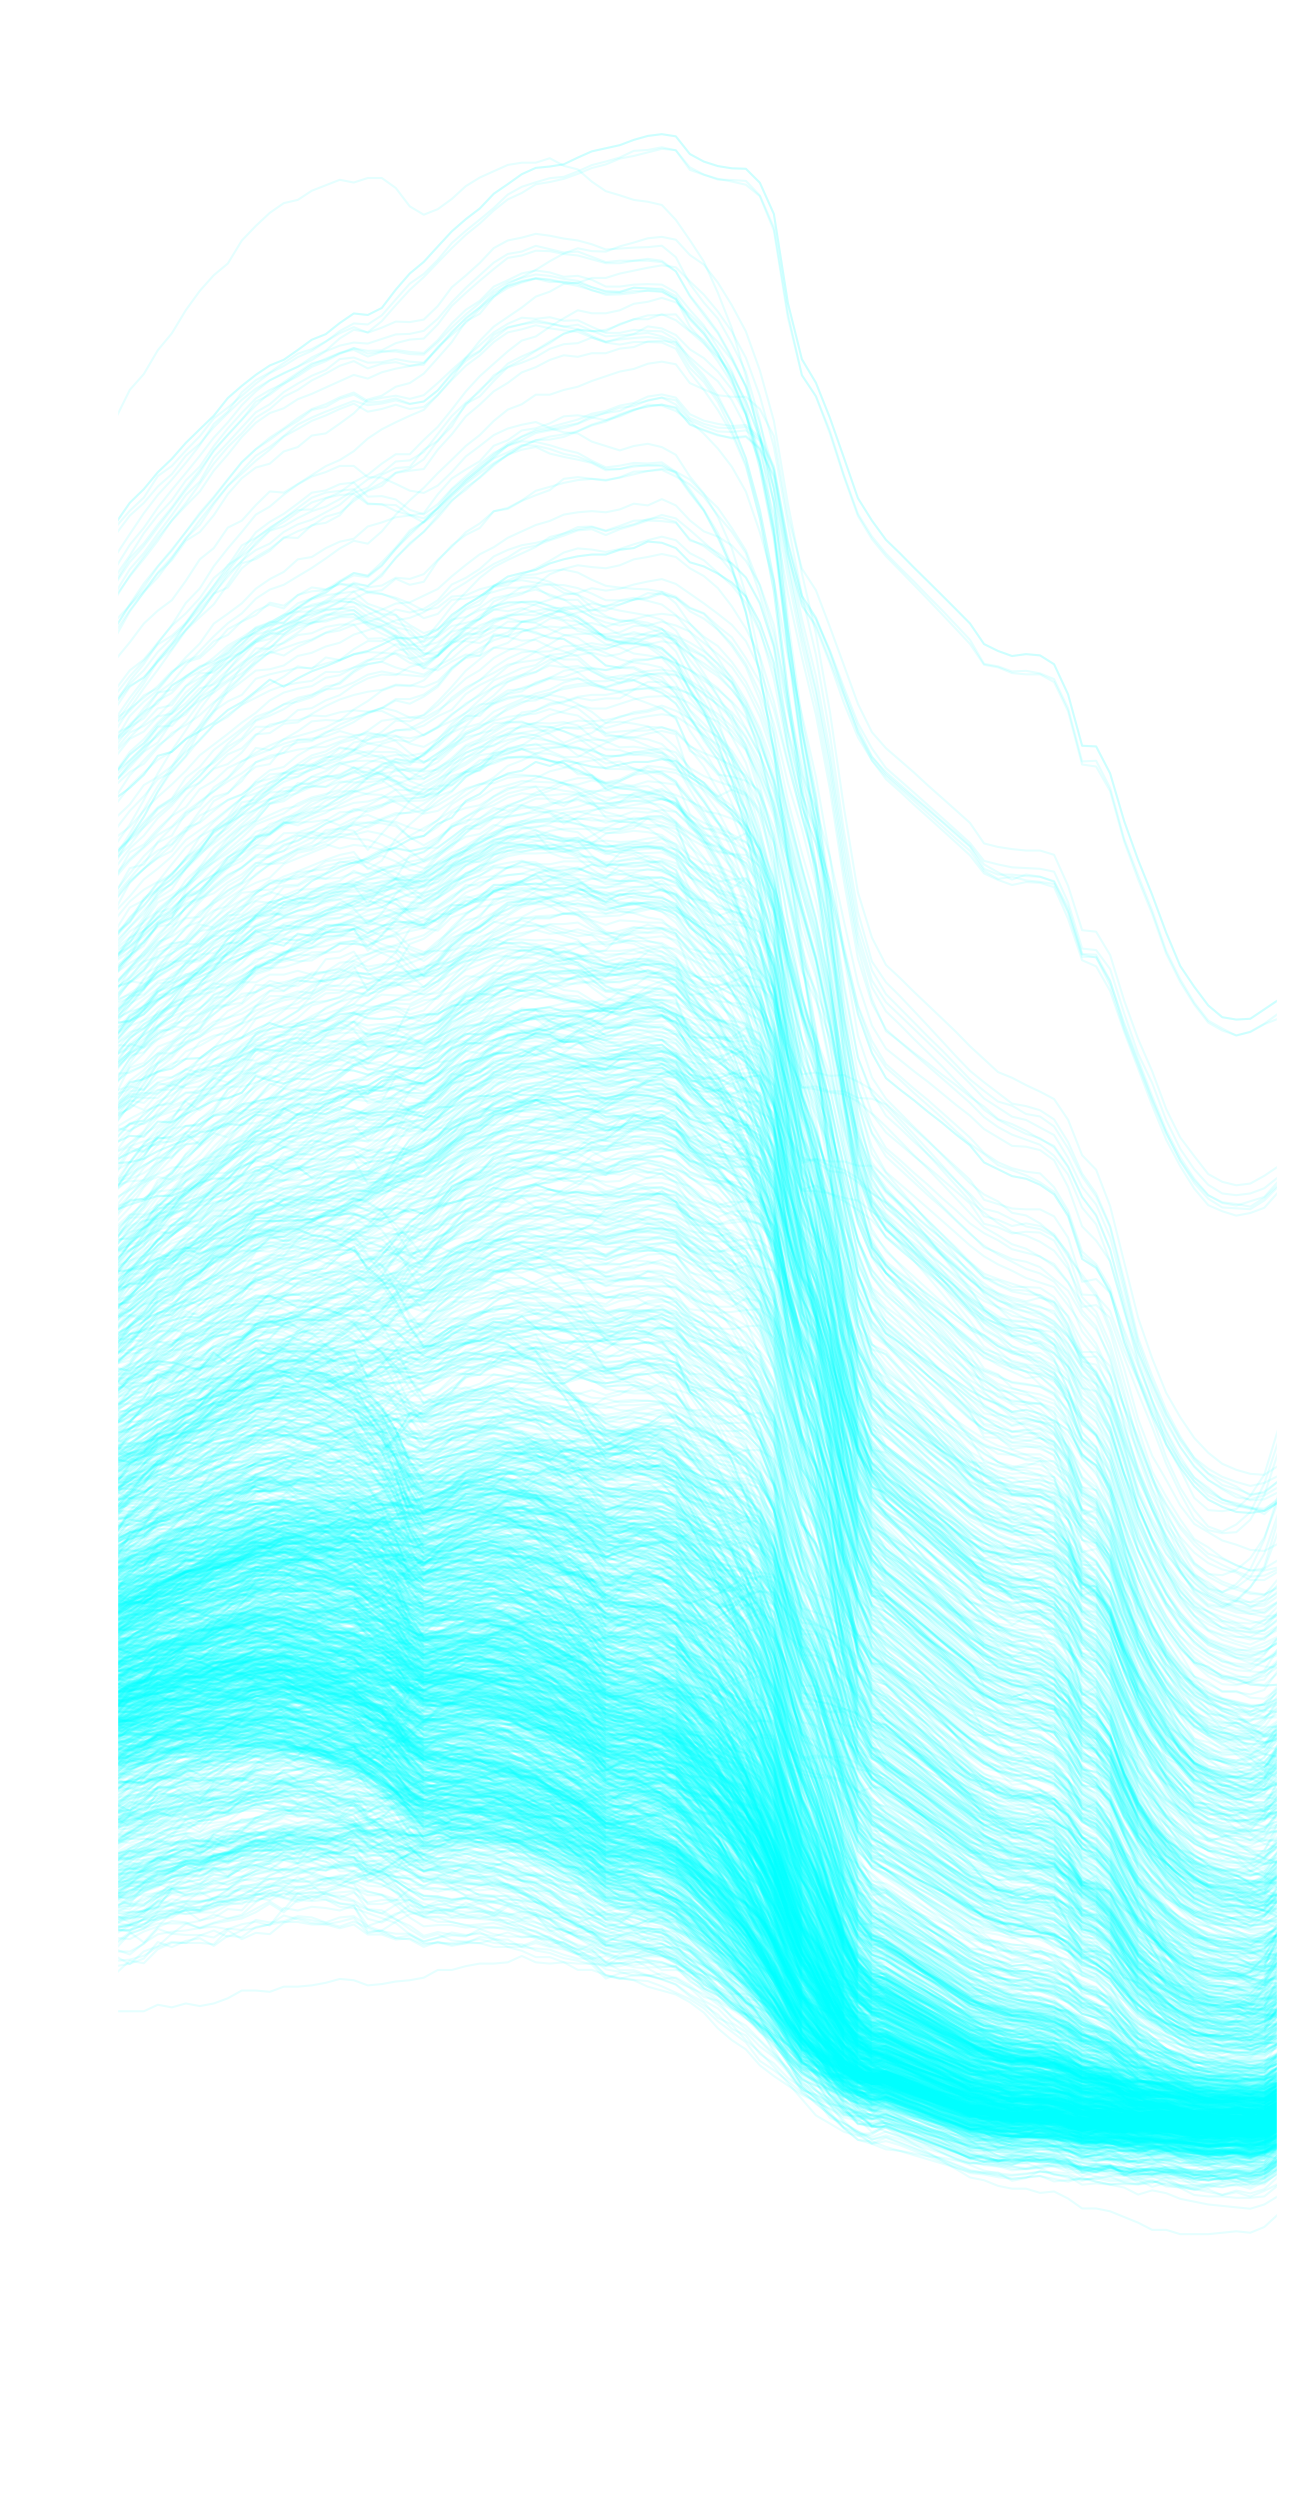

In [27]:
# clip spectra to AOP valid range (instrument calibration limitations)
ind = (spectra_corrected.columns > min(SENSOR_LIMS)) & (spectra_corrected.columns < max(SENSOR_LIMS))
prism_spectra = spectra_corrected.loc[:, ind]

validation_spectra_f, validation_spectra_ax = plt.subplots(1, 1, figsize=(5, 10), dpi=300)
validation_spectra_ax.plot(prism_spectra.columns, prism_spectra.values.T, color=(0,1,1,0.1), lw=0.5);
validation_spectra_ax.set_xlim(min(prism_spectra.columns), max(prism_spectra.columns));

validation_spectra_ax = plotting.format_axis_for_ppt(validation_spectra_ax) 
# [validation_spectra_ax.spines[pos].set_color('white') for pos in validation_spectra_ax.spines.keys()]
# # set ticks to be white
# validation_spectra_ax.tick_params(axis='x', colors='white')
# validation_spectra_ax.tick_params(axis='y', colors='white')
validation_spectra_ax.grid(True, color='white', ls='--', linewidth=0.5, alpha=0.5, which='both')
validation_spectra_ax.set_xlabel("Wavelength (nm)", color="white")
validation_spectra_ax.set_ylabel("Reflectance", color="white")
validation_spectra_ax.set_yticklabels([])
validation_spectra_f.savefig(file_ops.RESULTS_DIR_FP / "figures/validation_spectra.png", dpi=300, transparent=True)

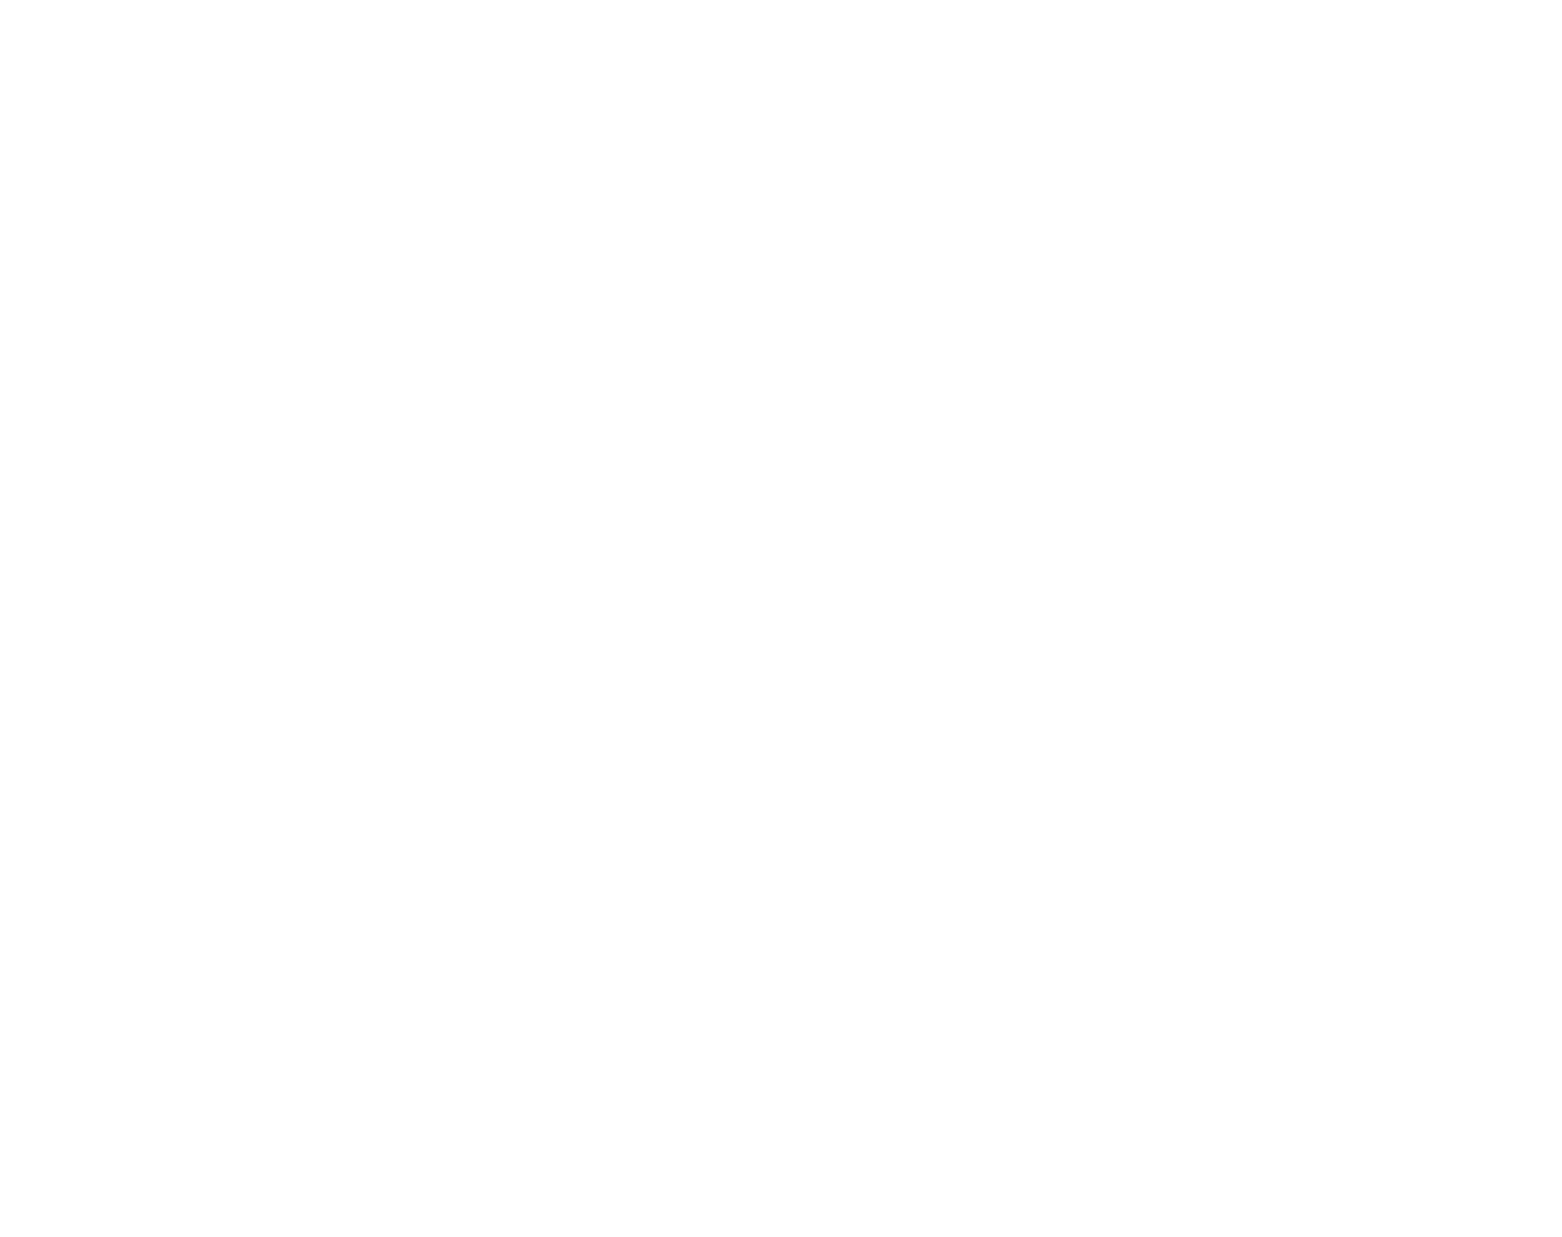

In [28]:
# create animation of spectra being added to figure, one by one
from matplotlib.animation import FuncAnimation

fig, ax = plt.subplots(1, 1, dpi=300)
ax.set_xlim(min(prism_spectra.columns), max(prism_spectra.columns))
lim_prism_spectra = prism_spectra.iloc[::10, :]
# order spectrum by size of first value
lim_prism_spectra = lim_prism_spectra.iloc[np.argsort(lim_prism_spectra.iloc[:, 0])]



# ax.set_ylim([0, 0.27])

def update(i):
    ax.cla()
    fig.patch.set_alpha(0.0)
    ax.patch.set_alpha(0.0)
    ax.plot(lim_prism_spectra.columns, lim_prism_spectra[:i].values.T, color=(0, 1, 1, 0.5), lw=0.5)
    ax.set_xlim(min(lim_prism_spectra.columns), max(lim_prism_spectra.columns))
    # format axis
    plotting.format_axis_for_ppt(ax)
    ax.grid(True, color='white', ls='--', linewidth=0.5, alpha=0.05, which='both')
    # set ytick labels empty
    ax.set_yticklabels([])
    ax.set_ylim(0, np.max(lim_prism_spectra.values.T)*1.1)
    return ax

ani = FuncAnimation(fig, update, frames=range(lim_prism_spectra.shape[0]), interval=1, repeat=False)
writer = FFMpegWriter(fps=30, metadata={'loop': 0}, extra_args=['-loop', '-1'])

# save animation with transparent background
ani.save(file_ops.RESULTS_DIR_FP / "figures/validation_spectra_animation_static.gif", writer=writer, savefig_kwargs={'transparent': True})

## Wavelength?

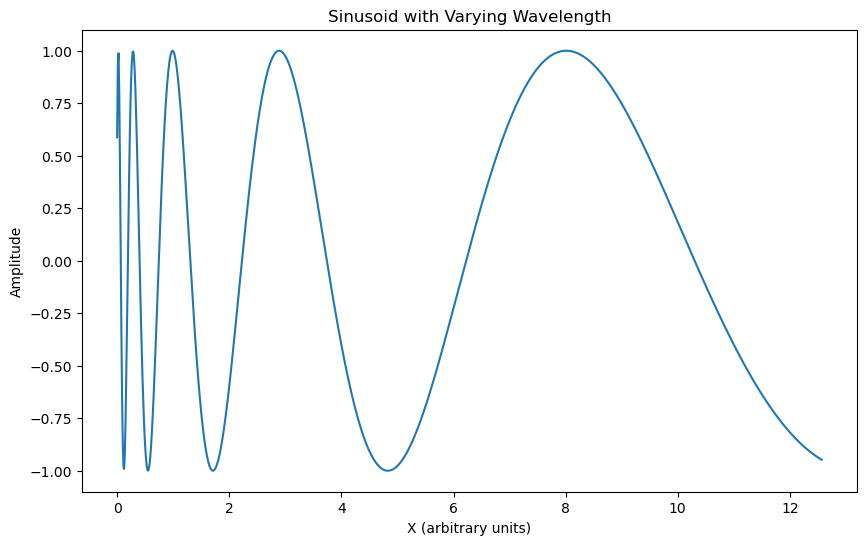

In [29]:
# plot sinusoid of varying wavelengths between min(wvs) and max(wvs)
import numpy as np
import matplotlib.pyplot as plt

# Define the range of wavelengths (in nm)
min_wavelength = 10
max_wavelength = 1000

# Define the x-axis range (in arbitrary units)
x = np.linspace(0, 4 * np.pi, 1000)

# Calculate the wavelength at each point on the x-axis
wavelengths = np.linspace(min_wavelength, max_wavelength, len(x))

# Calculate the frequency at each point on the x-axis (inverse of wavelength)
frequencies = 1 / wavelengths

# Generate the sinusoidal wave with varying frequency
y = np.sin(np.cumsum(frequencies) * 2 * np.pi)

# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the sinusoid
ax.plot(x, y)

# Add labels and title
ax.set_xlabel('X (arbitrary units)')
ax.set_ylabel('Amplitude')
ax.set_title('Sinusoid with Varying Wavelength')

# Show the plot
plt.show()

# Depth

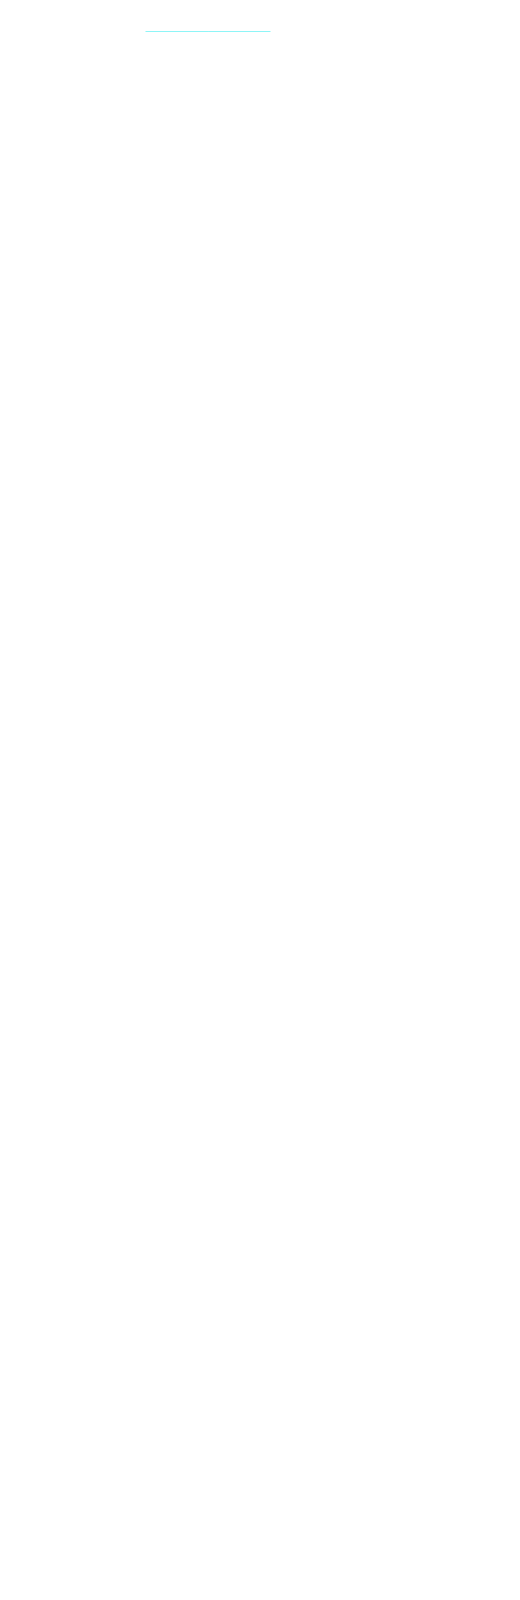

In [30]:
import matplotlib
from matplotlib.animation import FuncAnimation, FFMpegWriter, PillowWriter

# Set up the figure and axis
fig, ax = plt.subplots(figsize=(3, 10), dpi=200)

# Initialize the bar with a value of 0
bar = ax.bar(0, 0, width=0.1, color='blue')

# format
ax.set_xlim(-0.15, 0.15)
ax.set_ylim(-10.5, 0)
plotting.format_axis_for_ppt(ax)
ax.grid(True, color='white', ls='--', linewidth=0.5, alpha=0.05, which='both')
ax.set_xticklabels([])
ax.set_ylabel("Depth (m)", color="white", labelpad=0)  # Adjust labelpad to prevent cutoff
ax.yaxis.set_label_position("right")
ax.yaxis.tick_right()
ax.patch.set_alpha(0.0)
fig.patch.set_alpha(0.0)
fig.subplots_adjust(right=0.75)  # Adjust the right margin to prevent cutoff

n_frames = 100
max_depth = 10

lin = np.linspace(0,1,n_frames)
heights = (max_depth * (1-lin**2))[::-1]

# Define the colormap
start_hex = "#72F4F6"
end_hex = "#0f2e5a"
from matplotlib.colors import LinearSegmentedColormap
cmap = LinearSegmentedColormap.from_list("custom", [start_hex, end_hex], N=n_frames)

# Define the update function for the animation
def update(frame):
    height = -frame  # Height decreases from 0 to -10
    # for h in heights:
    color = cmap(int(frame*(n_frames/max_depth)))
    bar[0].set_height(height)  # Update bar height
    bar[0].set_color(color)  # Update bar color
    return bar

ani = FuncAnimation(fig, update, frames=heights, repeat=False)

# save animation with transparent background
writer = FFMpegWriter(fps=30, extra_args=['-loop', '-1'])
# writer = PillowWriter(fps=40)
ani.save(file_ops.RESULTS_DIR_FP / "figures/height.mp4", writer=writer, savefig_kwargs={'transparent': True})

# What is Kaneohe Bay?
Visualising the distributions of the different sites

In [31]:
validation_data = pd.read_csv(file_ops.DATA_DIR_FP / "CORAL_validation_data.csv")
import matplotlib.colors as mcolors

# Get colours from a sequential colormap
cmap = plotting.ColourMapGenerator().get_cmap("seq")
# Generate colors for each point
colours = [mcolors.rgb2hex(cmap(step)) for step in np.linspace(0, 1, len(validation_data.Locale.unique()))]


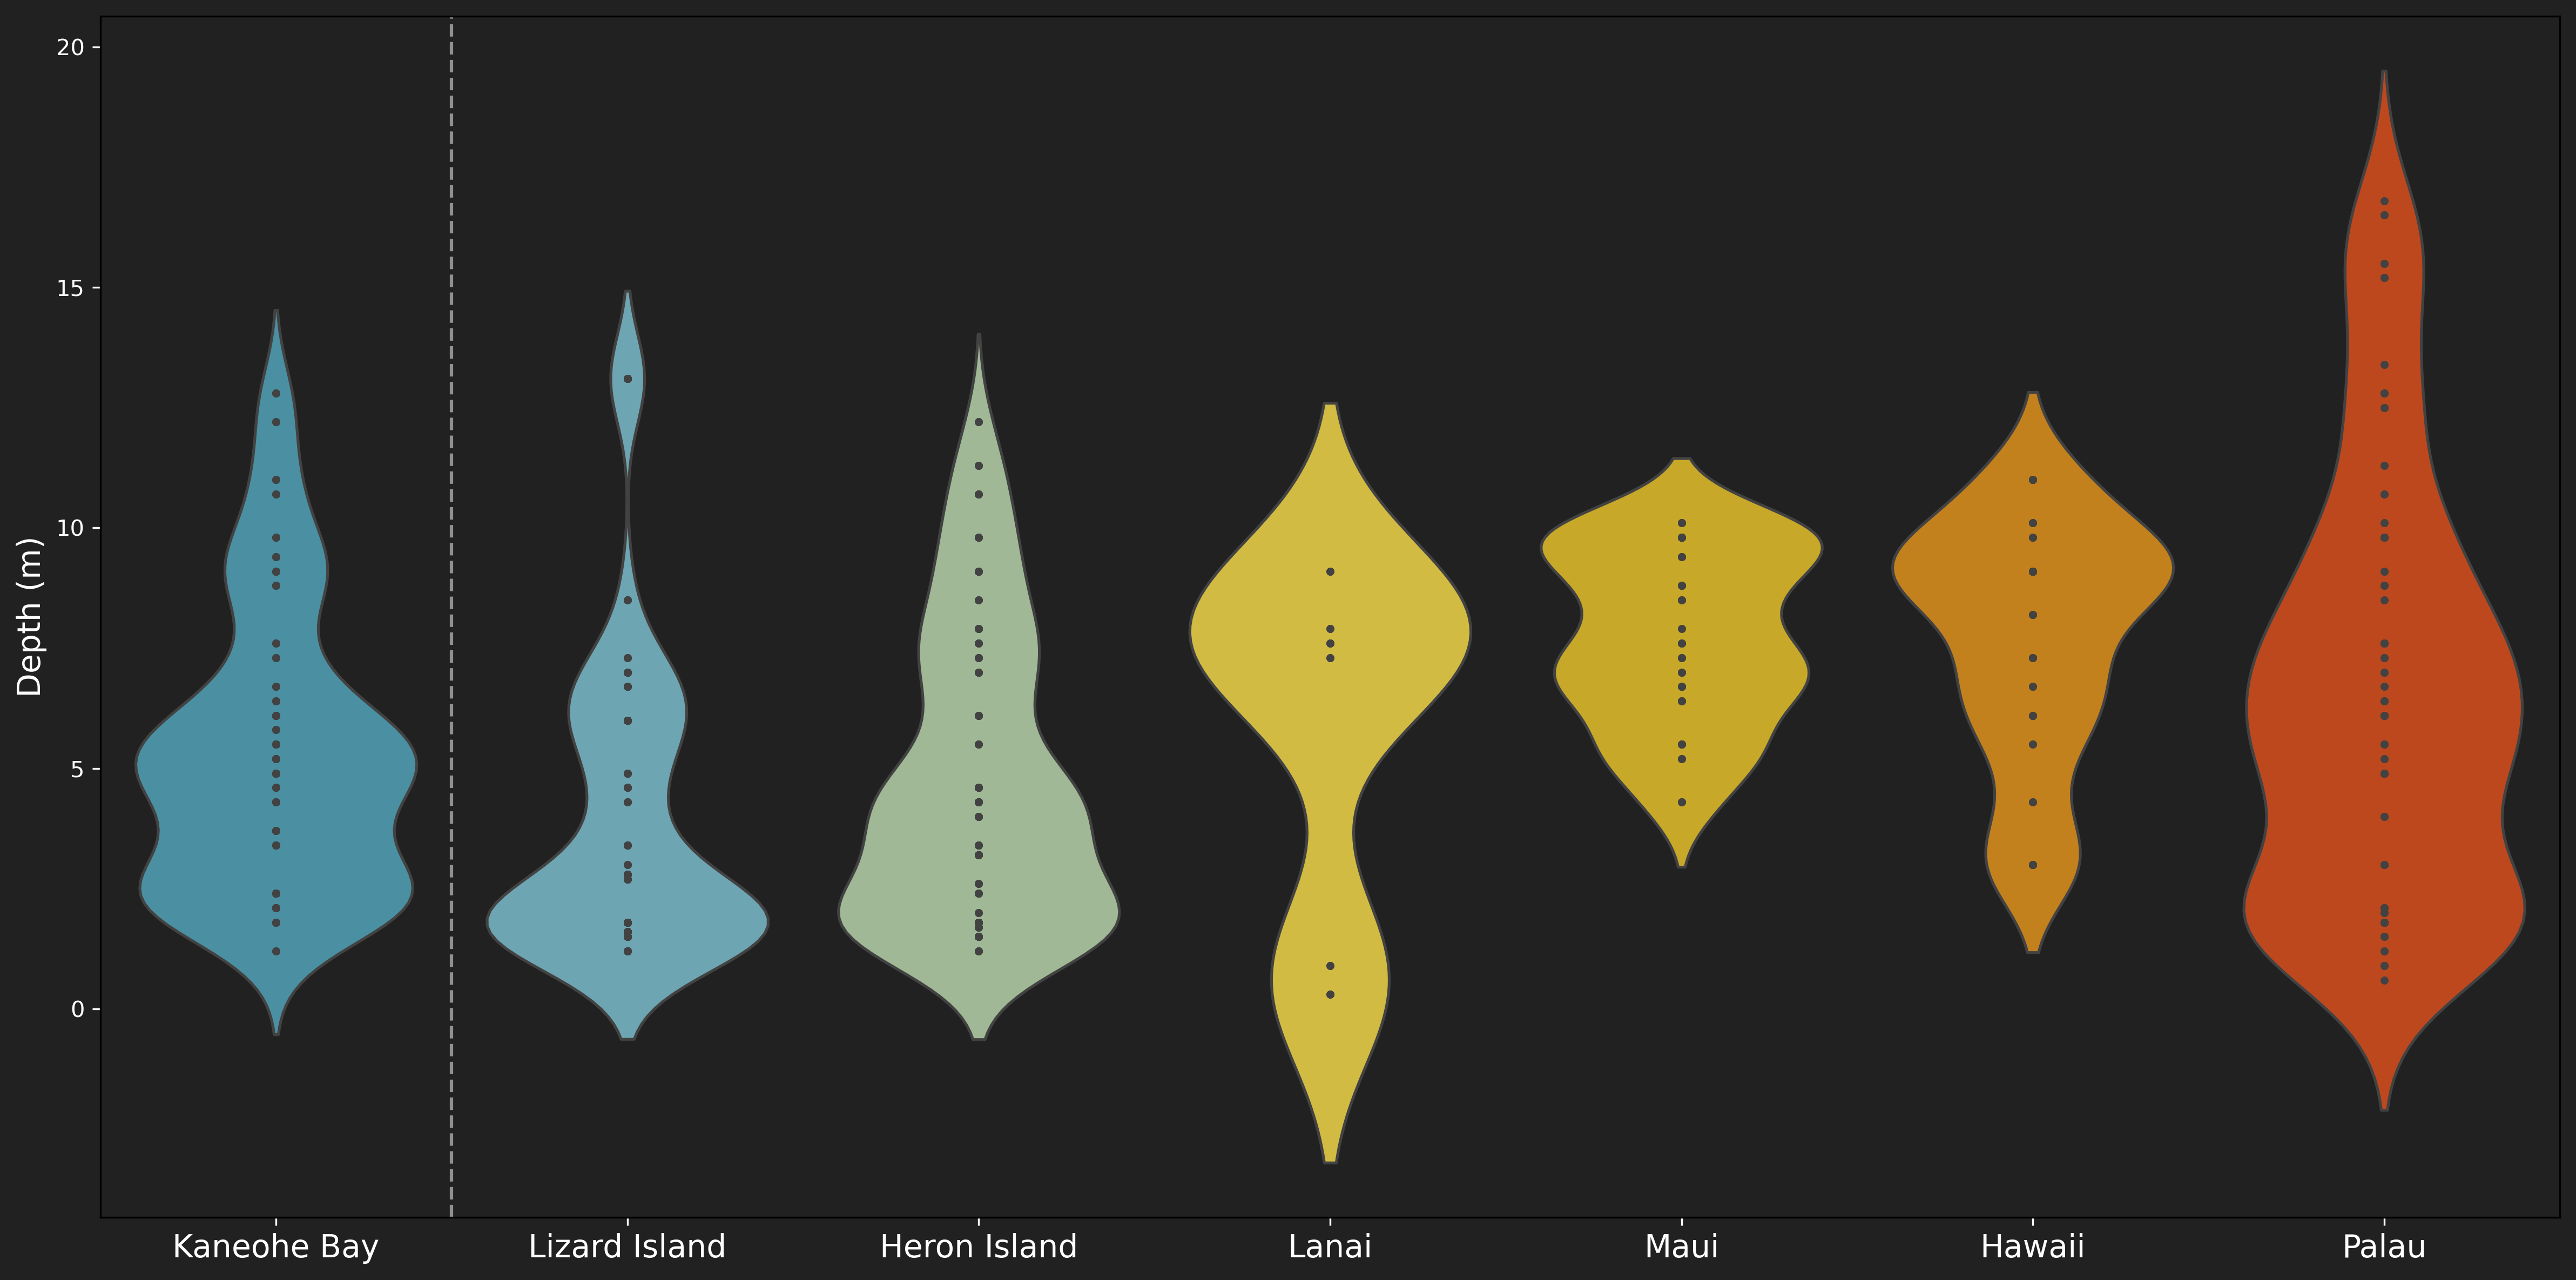

In [32]:
# Reorder validation_data to have Kaneohe Bay as the first entry
validation_data_reordered = pd.concat([validation_data[validation_data["Locale"] == "Kaneohe Bay"], 
                                       validation_data[validation_data["Locale"] != "Kaneohe Bay"]])

import seaborn as sns
# Plot depth distributions
fig, ax = plt.subplots(figsize=(16, 8), dpi=300)
sns.violinplot(x="Locale", y="Depth", hue="Locale", data=validation_data_reordered, ax=ax, inner="point", palette=colours)
# ax.set_xlabel("Site")
ax.set_xlabel("")
ax.set_ylabel("Depth (m)", fontsize=14)
# ax.set_title("Depth Distributions by Site")
ax.axvline(0.5, color="black", linestyle="--", alpha=0.5, c="white")
plotting.customize_plot_colors(fig, ax)
# increase font sizes
ax.tick_params(axis='x', which='major', labelsize=14)
plt.tight_layout()
plt.show()



In [33]:
benthic_types = validation_data.columns[11:-2]
benthic_validation = validation_data[list(benthic_types) + ["Locale"]].copy()

benthic_validation[benthic_types] = benthic_validation[benthic_types].astype(float)
benthic_validation.loc[:, benthic_types] = benthic_validation[benthic_types].div(benthic_validation[benthic_types].sum(axis=1), axis=0) * 100
benthic_validation

algCCA  algCyano  algMacBrn  algMacGrn  algMacMix  algMacRed  \
0      3.000000       2.0        0.0        1.0        0.0        4.0   
1      3.000000       2.0        0.0        1.0        0.0        4.0   
2      3.000000       2.0        0.0        1.0        0.0        4.0   
3      3.000000       2.0        0.0        1.0        0.0        4.0   
4      3.000000       2.0        0.0        1.0        0.0        4.0   
...         ...       ...        ...        ...        ...        ...   
1933   3.061224       0.0        0.0        0.0        0.0        0.0   
1934   3.061224       0.0        0.0        0.0        0.0        0.0   
1935  10.000000       0.0        0.0        0.0        0.0        2.0   
1936  10.000000       0.0        0.0        0.0        0.0        2.0   
1937  10.000000       0.0        0.0        0.0        0.0        2.0   

      algMacUnk    algTurf   crlCoral  crlBleach  ...  othClam  othInvert  \
0           0.0  62.000000   1.000000        0.0  ...      0.0        0.0   
1           0.0  62.000000   1.000000        0.0  ...      0.0        0.0   
2           0.0  62.000000   1.000000        0.0  ...      0.0        0.0   
3           0.0  62.000000   1.000000        0.0  ...      0.0        0.0   
4           0.0  62.000000   1.000000        0.0  ...      0.0        0.0   
...         ...        ...        ...        ...  ...      ...        ...   
1933        0.0  57.142857  35.714286        0.0  ...      0.0        0.0   
1934        0.0  57.142857  35.714286        0.0  ...      0.0        0.0   
1935        0.0  38.000000  48.000000        0.0  ...      0.0        0.0   
1936        0.0  38.000000  48.000000        0.0  ...      0.0        0.0   
1937        0.0  38.000000  48.000000        0.0  ...      0.0        0.0   

      othOther  othSponge  othUrchin  sedLimest  sedMud  sedRubble    sedSand  \
0          0.0        0.0        0.0        0.0     0.0        0.0  27.000000   
1          0.0        0.0        0.0        0.0     0.0        0.0  27.000000   
2          0.0        0.0        0.0        0.0     0.0        0.0  27.000000   
3          0.0        0.0        0.0        0.0     0.0        0.0  27.000000   
4          0.0        0.0        0.0        0.0     0.0        0.0  27.000000   
...        ...        ...        ...        ...     ...        ...        ...   
1933       0.0        0.0        0.0        0.0     0.0        0.0   3.061224   
1934       0.0        0.0        0.0        0.0     0.0        0.0   3.061224   
1935       0.0        1.0        0.0        0.0     0.0        0.0   1.000000   
1936       0.0        1.0        0.0        0.0     0.0        0.0   1.000000   
1937       0.0        1.0        0.0        0.0     0.0        0.0   1.000000   

             Locale  
0     Lizard Island  
1     Lizard Island  
2     Lizard Island  
3     Lizard Island  
4     Lizard Island  
...             ...  
1933          Palau  
1934          Palau  
1935          Palau  
1936          Palau  
1937          Palau  

[1938 rows x 22 columns]

In [34]:
benthic_grouped = benthic_validation.set_index("Locale")
# take mean by index (locale)
benthic_grouped = benthic_grouped.groupby("Locale").mean()
benthic_grouped

algCCA  algCyano  algMacBrn  algMacGrn  algMacMix  \
Locale                                                                
Hawaii         12.809859  0.000000   0.126761   0.000000   0.000000   
Heron Island    5.726078  0.114504   0.917692   1.418601   0.969383   
Kaneohe Bay     7.783263  0.242280   0.232779   0.200113   0.462784   
Lanai          10.082067  0.000000   4.331307   1.519757   0.607903   
Lizard Island   2.783970  1.066752   0.870956   0.608518   0.943868   
Maui            4.969849  0.000000   0.000000   0.059259   0.000000   
Palau          13.060725  0.000000   1.762173   1.135195   0.877573   

               algMacRed  algMacUnk    algTurf   crlCoral  crlBleach  ...  \
Locale                                                                ...   
Hawaii          0.267606   0.000000  64.021127  10.605634   0.000000  ...   
Heron Island    1.781420   0.000000  31.793045  38.479342   0.101987  ...   
Kaneohe Bay     1.743869   0.128854  53.320212  30.091719   0.023753  ...   
Lanai           4.246201   0.000000  19.379939  57.100304   0.294833  ...   
Lizard Island   2.742957   0.136724  57.260914   4.992034   0.018868  ...   
Maui            0.059858   0.000000  45.888107  33.245986   0.000000  ...   
Palau           0.642678   0.000000  27.680205  36.679741   0.000000  ...   

               othSeagr   othClam  othInvert  othOther  othSponge  othUrchin  \
Locale                                                                         
Hawaii         0.000000  0.000000   0.000000       0.0   0.000000   0.169014   
Heron Island   0.033079  0.000000   0.087137       0.0   0.022901   0.000000   
Kaneohe Bay    0.000000  0.000000   0.000000       0.0   0.000000   0.000000   
Lanai          0.000000  0.000000   0.580547       0.0   0.714286   0.000000   
Lizard Island  0.000000  0.192307   0.059583       0.0   0.133187   0.000000   
Maui           0.000000  0.000000   0.000000       0.0   0.000000   0.032922   
Palau          0.000000  0.000000   0.232041       0.0   0.160819   0.000000   

               sedLimest  sedMud  sedRubble    sedSand  
Locale                                                  
Hawaii          0.000000     0.0   0.000000  12.000000  
Heron Island    0.000000     0.0   1.043629  15.171823  
Kaneohe Bay     0.000000     0.0   0.242280   5.509092  
Lanai           0.000000     0.0   0.000000   1.142857  
Lizard Island   0.000000     0.0   6.938761  16.312438  
Maui            0.000000     0.0   0.000000  15.744019  
Palau           0.056855     0.0   0.017544  16.599668  

[7 rows x 21 columns]

In [35]:
class_map = file_ops.read_yaml(file_ops.CONFIG_DIR_FP / "glob_cfg.yaml")["endmember_map"]
# apply class map to columns, summing
benthic_grouped = spectrum_utils.convert_df_classes(benthic_grouped.T, class_map).T

# additionally sum any columns containing "coral" in the header
coral_cols = [col for col in benthic_grouped.columns if "coral" in col]
benthic_grouped["coral"] = benthic_grouped[coral_cols].sum(axis=1)
benthic_grouped = benthic_grouped.drop(columns=coral_cols)


# rename columns
column_dict = {
    "algae_crustose_coralline": "CCA",
    "algae_fleshy_green": "Fleshy Green Algae",
    "algae_fleshy_red": "Fleshy Red Algae",
    "algae_fleshy_brown": "Fleshy Brown Algae",
    "algae_turf": "Turf Algae",    
}
benthic_grouped = benthic_grouped.rename(columns=column_dict)

(<Figure size 4800x2400 with 1 Axes>, <Axes: xlabel='Percentage Cover (%)'>)

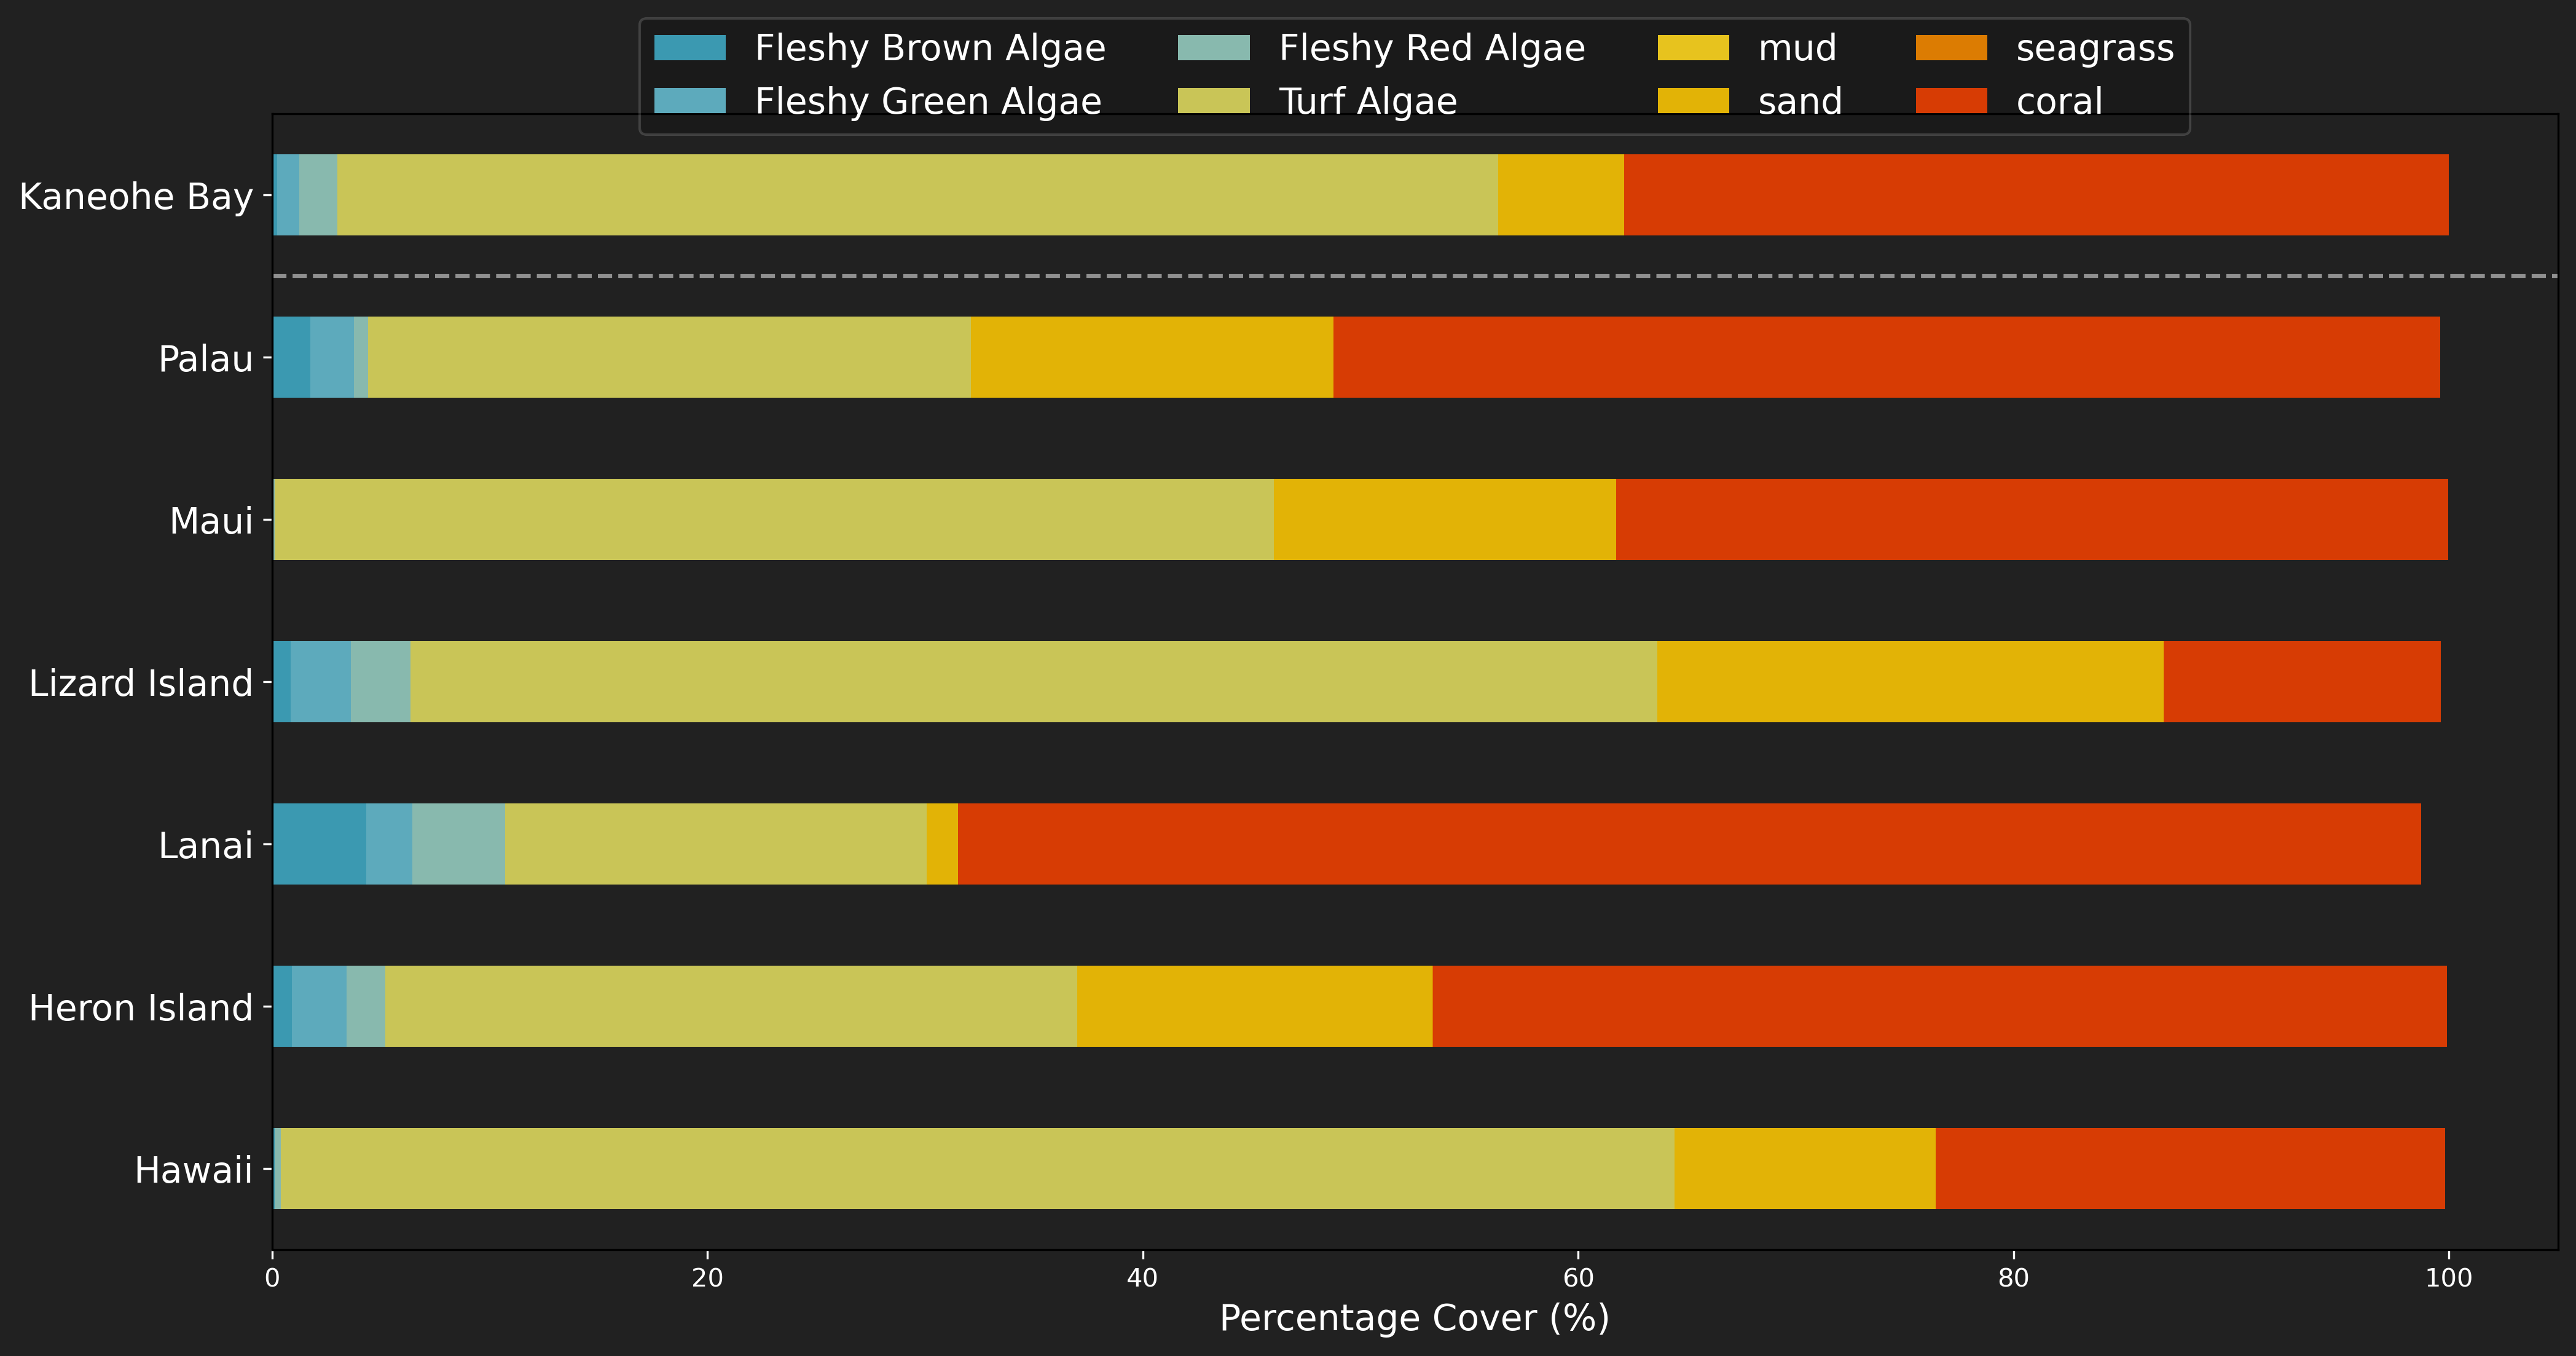

In [36]:
# Reorder benthic_grouped to have Kaneohe Bay as the first entry
benthic_grouped = benthic_grouped.reindex([loc for loc in benthic_grouped.index if loc != 'Kaneohe Bay'] + ['Kaneohe Bay'])

# Plot stacked bar chart for each locale
fig, ax = plt.subplots(figsize=(16, 8), dpi=300)
benthic_colours = [mcolors.rgb2hex(cmap(step)) for step in np.linspace(0, 1, len(benthic_grouped.columns))]

stacked = benthic_grouped.plot(kind="barh", stacked=True, ax=ax, color=benthic_colours)
ax.set_ylabel("")
ax.set_xlabel("Percentage Cover (%)", fontsize=14)
ax.legend(ncol=len(benthic_grouped.columns)/2, loc="upper center", bbox_to_anchor=(0.5, 1.1), fontsize=14, facecolor='black', framealpha=0.2)
ax.tick_params(axis='y', which='major', labelsize=14)

ax.axhline(5.5, color="black", linestyle="--", alpha=0.5, c="white");
plotting.customize_plot_colors(fig, ax)

# Animate fitting process

In [37]:
endmember_array

390.346814  393.177859  396.008959  398.840115  401.671328  404.502597  \
class                                                                           
algae    0.032693    0.032358    0.032033    0.031743    0.031435    0.031075   
coral    0.026952    0.026773    0.026528    0.026365    0.026313    0.026305   
sand     0.049409    0.048710    0.048008    0.047479    0.047214    0.047199   

       407.333922  410.165304  412.996742  415.828236  ...  682.239779  \
class                                                  ...               
algae    0.030714    0.030374    0.030073    0.029821  ...    0.047058   
coral    0.026309    0.026274    0.026181    0.026045  ...    0.049318   
sand     0.047346    0.047557    0.047766    0.047981  ...    0.087355   

       685.076616  687.913509  690.750458  693.587464  696.424526  699.261643  \
class                                                                           
algae    0.051372    0.057830    0.066687    0.077965    0.091349    0.106277   
coral    0.058494    0.073355    0.094753    0.122312    0.154187    0.187547   
sand     0.089554    0.092270    0.095322    0.098469    0.101472    0.104175   

       702.098818  704.936048  707.773335  
class                                      
algae    0.122033    0.137973    0.153615  
coral    0.219428    0.247827    0.271757  
sand     0.106522    0.108535    0.110297  

[3 rows x 113 columns]

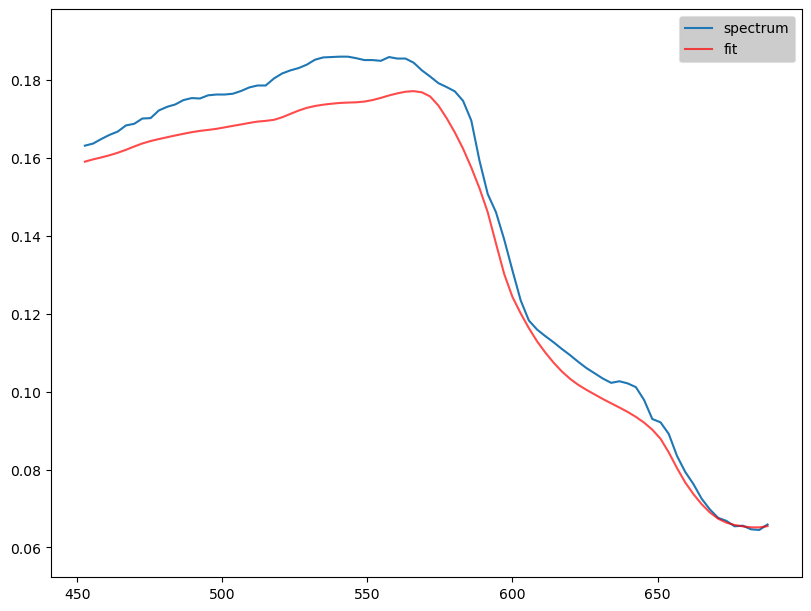

In [41]:
# minimise a single spectrum
i = 4

from scipy.optimize import minimize
from sklearn.metrics import r2_score
glob_cfg, _ = file_ops.instantiate_single_configs_instance(run_ind = 0)
AOP_model = spectrum_utils.load_aop_model(aop_group_num=1)

# cropped AOP_args
short_AOP_args = spectrum_utils.process_aop_model(AOP_model)
short_endmember_array = spectrum_utils.crop_spectra_to_range(endmember_array, spectrum_utils.SENSOR_RANGE)

endmember_bounds = (0, np.inf)

# Create a list to store the fit results at each step
fit_results = []

def callback(x):
    fit_results.append(x)

fit = minimize(
    spectrum_utils.r2_objective_fn,
    x0=[0.1, 0.1, 0] + [0.0001] * len(short_endmember_array),
    args=(prism_spectra.loc[i], *short_AOP_args, short_endmember_array),
    bounds=[(0, 0.41123), (0.01688, 3.17231), (0, 50)] + [endmember_bounds] * len(short_endmember_array),
    callback=callback
)

fig, ax = plt.subplots(1, 1, sharex=True, constrained_layout=True, figsize=(8, 6))

def update(frame):
    ax.cla()
    
    ax.patch.set_alpha(0)
    fig.patch.set_alpha(0)
    ax.plot(prism_spectra.columns, prism_spectra.loc[i], label='spectrum')
    ax.plot(prism_spectra.columns, spectrum_utils.sub_surface_reflectance_Rb(prism_spectra.columns, short_endmember_array, bb, K, H, short_AOP_args, *fit_results[frame][3:]), color='red', alpha=0.7, label='fit')
    ax.legend(facecolor='black', framealpha=0.2)
    val_range = np.max(prism_spectra.loc[i]) - np.min(prism_spectra.loc[i])
    ax.set_ylim(np.min(prism_spectra.loc[i])-0.1*val_range, np.max(prism_spectra.loc[i])+0.1*val_range)
    plotting.format_axis_for_ppt(K_axes)
    K_axes.grid(True, color='white', ls='--', linewidth=0.5, alpha=0.5, which='both')
    K_axes.set_xlabel("Wavelength (nm)", color="white")

    
ani = FuncAnimation(fig, update, frames=len(fit_results), repeat=False)


# save animation with transparent background
writer = FFMpegWriter(fps=8, extra_args=['-loop', '-1'])
ani.save(file_ops.RESULTS_DIR_FP / "figures/fit_animation.gif", writer=writer, savefig_kwargs={'transparent': True})


In [2]:
from scipy.optimize import minimize
from sklearn.metrics import r2_score
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, FFMpegWriter

# Your existing setup code here
glob_cfg, _ = file_ops.instantiate_single_configs_instance(run_ind=0)
AOP_model = spectrum_utils.load_aop_model(aop_group_num=1)
short_AOP_args = spectrum_utils.process_aop_model(AOP_model)
short_endmember_array = spectrum_utils.crop_spectra_to_range(endmember_array, spectrum_utils.SENSOR_RANGE)
endmember_bounds = (0, np.inf)

# Create a list to store fit results and determine max iterations required
fit_results_list = []
max_iter_length = 0


sample_spectra = [0, 300, 400]

for i in sample_spectra:
    fit_results = []
    
    def callback(x):
        fit_results.append(x)
    
    fit = minimize(
        spectrum_utils.r2_objective_fn,
        x0=[0.1, 0.1, 0] + [0.0001] * len(short_endmember_array),
        args=(prism_spectra.loc[i], *short_AOP_args, short_endmember_array),
        bounds=[(0, 0.41123), (0.01688, 3.17231), (0, 50)] + [endmember_bounds] * len(short_endmember_array),
        callback=callback,
        tol=1e-8
    )
    
    max_iter_length = max(max_iter_length, len(fit_results))
    fit_results_list.append(fit_results)

# Pad each fit_results to max_iter_length
for fit_results in fit_results_list:
    while len(fit_results) < max_iter_length:
        fit_results.append(fit_results[-1])

# Flatten the list to iterate over all frames
fit_results_flat = [fit for sublist in fit_results_list for fit in sublist]

# Initialize figure for animation
fig, ax = plt.subplots(figsize=(10, 3), dpi=200)

# Index to track the current sample in sample_spectra
current_sample_index = 0

def update(frame):
    global current_sample_index
    ax.cla()
    ax.patch.set_alpha(0)
    fig.patch.set_alpha(0)
    fig.subplots_adjust(bottom=0)

    # Change spectrum when reaching the start of a new sample spectrum
    if frame % max_iter_length == 0 and frame > 0:
        current_sample_index += 1
    
    fit_frame = frame % max_iter_length
    spectrum_index = sample_spectra[current_sample_index]
    
    if current_sample_index < len(sample_spectra):
        bb, K, H, *Rb = fit_results_flat[frame]
        fitted_spectrum = spectrum_utils.sub_surface_reflectance_Rb(
            prism_spectra.columns, short_endmember_array, bb, K, H, short_AOP_args, *Rb)
        
        ax.plot(prism_spectra.columns, prism_spectra.loc[spectrum_index], label=f'Spectrum {spectrum_index}', color="#3B9AB2")
        ax.plot(prism_spectra.columns, fitted_spectrum, color='#d83c04', alpha=1, label='Fit')
        
        r2 = r2_score(prism_spectra.loc[spectrum_index], fitted_spectrum)
        ax.text(0.02, 0.96, f"r$^2$: {r2:.4f}", color="white", ha="left", va="top", transform=ax.transAxes, fontsize=16)
        
        plotting.format_axis_for_ppt(ax)
        ax.legend(facecolor='black', framealpha=0.3, labelcolor="white", fontsize=12, loc="upper right")
        ax.grid(True, color='white', ls='--', linewidth=0.5, alpha=0.5, which='both')
        ax.set_xlabel("Wavelength (nm)", color="white")
        ax.set_ylabel("Reflectance", color="white")
        ax.set_yticklabels([])
        ax.set_xlim(prism_spectra.columns.min(), prism_spectra.columns.max())
        
        # Set y limits to handle dynamic range
        val_range = np.max(prism_spectra.loc[spectrum_index]) - np.min(prism_spectra.loc[spectrum_index])
        ax.set_ylim(np.min(prism_spectra.loc[spectrum_index]) - 0.1 * val_range,
                    np.max(prism_spectra.loc[spectrum_index]) + 0.3 * val_range)

# Set up the animation
ani = FuncAnimation(fig, update, frames=len(sample_spectra) * max_iter_length, repeat=False)
writer = FFMpegWriter(fps=12, extra_args=['-loop', '-1'])
ani.save(file_ops.RESULTS_DIR_FP / "figures/fit_animation.gif", writer=writer, savefig_kwargs={'transparent': True})

NameError: name 'endmember_array' is not defined

In [51]:
# plot corresponding endmember contributions
short_wvs = wvs[(wvs >= min(prism_spectra.columns)) & (wvs <= max(prism_spectra.columns))]
bb, K, H, *Rb = fit_results_flat[-1]
fitted_spectrum = spectrum_utils.Rb_endmember(
    short_endmember_array, *Rb)    

fig, ax = plt.subplots(1, 1, figsize=(10, 4), dpi=300)
ax.patch.set_alpha(0)
fig.patch.set_alpha(0)
ax.plot(
    short_wvs,
    fitted_spectrum,
    color="white",
    alpha=0.7,
    label="Extracted Rb",
)

endmember_contribution = (short_endmember_array.T * fit.x[
    3 : 3 + len(short_endmember_array)
])

cmap = plt.get_cmap("tab20")
cdict = {
    "algae": "#195c21",
    "coral": "coral",
    "sand": "#ffed87",
}
# generate colour as a sum of the components
color_dict = {c: plt.cm.tab20(i) for i, c in enumerate(endmember_cats)}
y = np.zeros(endmember_contribution.shape[0])
# for label, endmember in zip(endmember_cats, endmember_contribution):
for i, (key, endmember) in enumerate(endmember_contribution.T.iterrows()):
    ynew = np.array(y + np.array(endmember, dtype=np.float32))
    ax.fill_between(
        short_wvs,
        y,
        ynew,
        label=endmember_cats[i],
        # lw=0,
        # color=color_dict[endmember_cats[i]],
        color=cdict[endmember_cats[i]],
        # alpha=0.5,
    )
    y = ynew
    

plotting.format_axis_for_ppt(ax)
ax.legend(facecolor='black', framealpha=0.3, labelcolor="white", fontsize=12)
ax.grid(True, color='white', ls='--', linewidth=0.5, alpha=0.5, which='both')
ax.set_xlabel("Wavelength (nm)", color="white")
ax.set_ylabel("Reflectance", color="white")
ax.set_yticklabels([])
ax.set_xlim(prism_spectra.columns.min(), prism_spectra.columns.max());

NameError: name 'fit_results_flat' is not defined

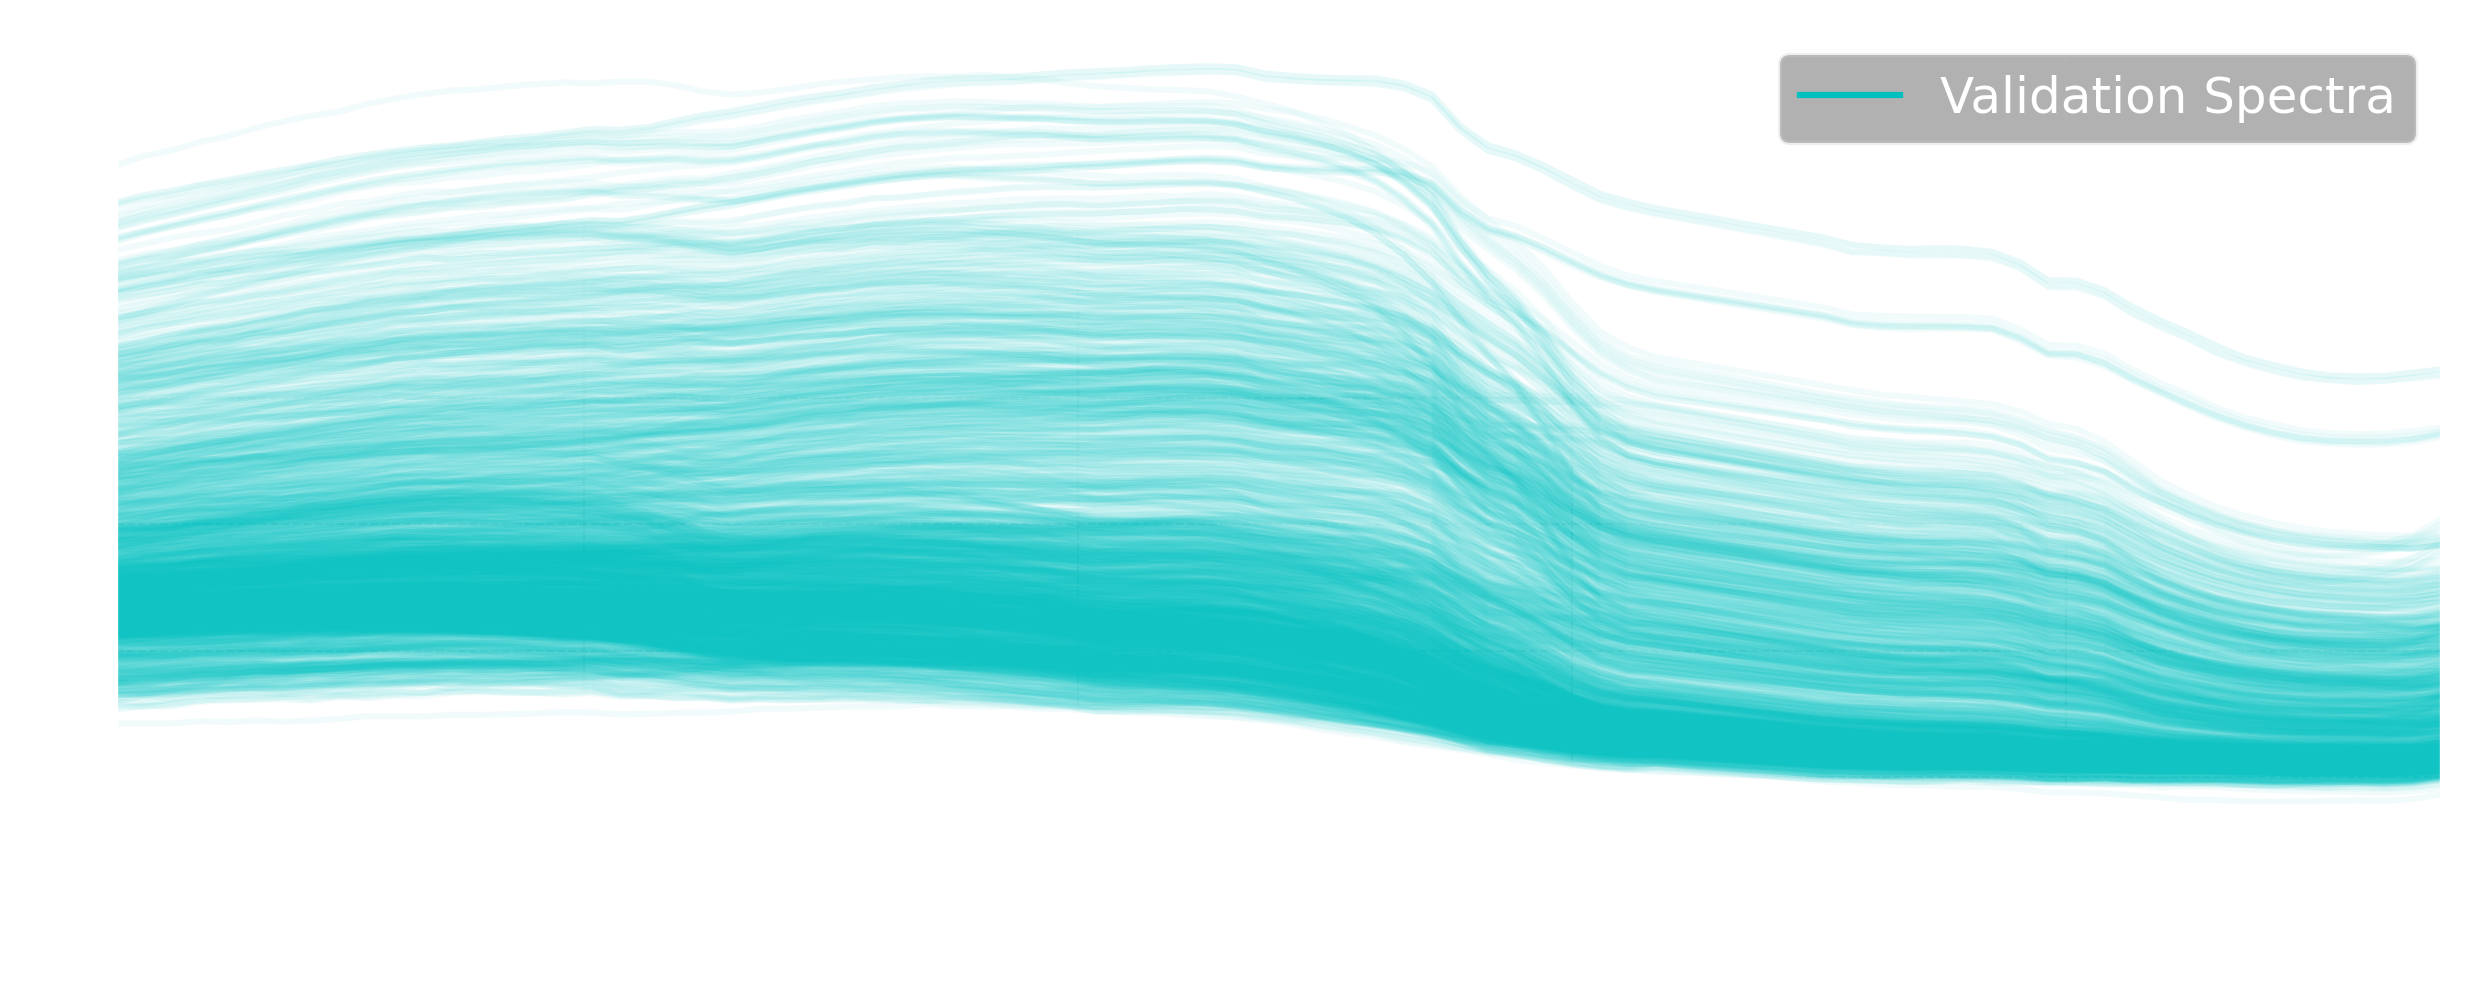

In [74]:
fig, ax = plt.subplots(1, 1, figsize=(10, 3.5), dpi=300)
fig.patch.set_alpha(0)
ax.patch.set_alpha(0)
ax.plot(prism_spectra.T, alpha=0.05, c="c")
ax.grid(True, color='white', ls='--', linewidth=0.5, alpha=0.5, which='both')
ax.set_xlim(min(prism_spectra.columns), max(prism_spectra.columns))
ax.set_xlabel("Wavelength (nm)", color="white")
ax.set_ylabel("Reflectance", color="white")
ax.set_yticklabels([])
plotting.format_axis_for_ppt(ax)
ax.plot([], [], label="Validation Spectra", color="c", alpha=1)
ax.legend(facecolor='black', framealpha=0.3, labelcolor="white", fontsize=12)

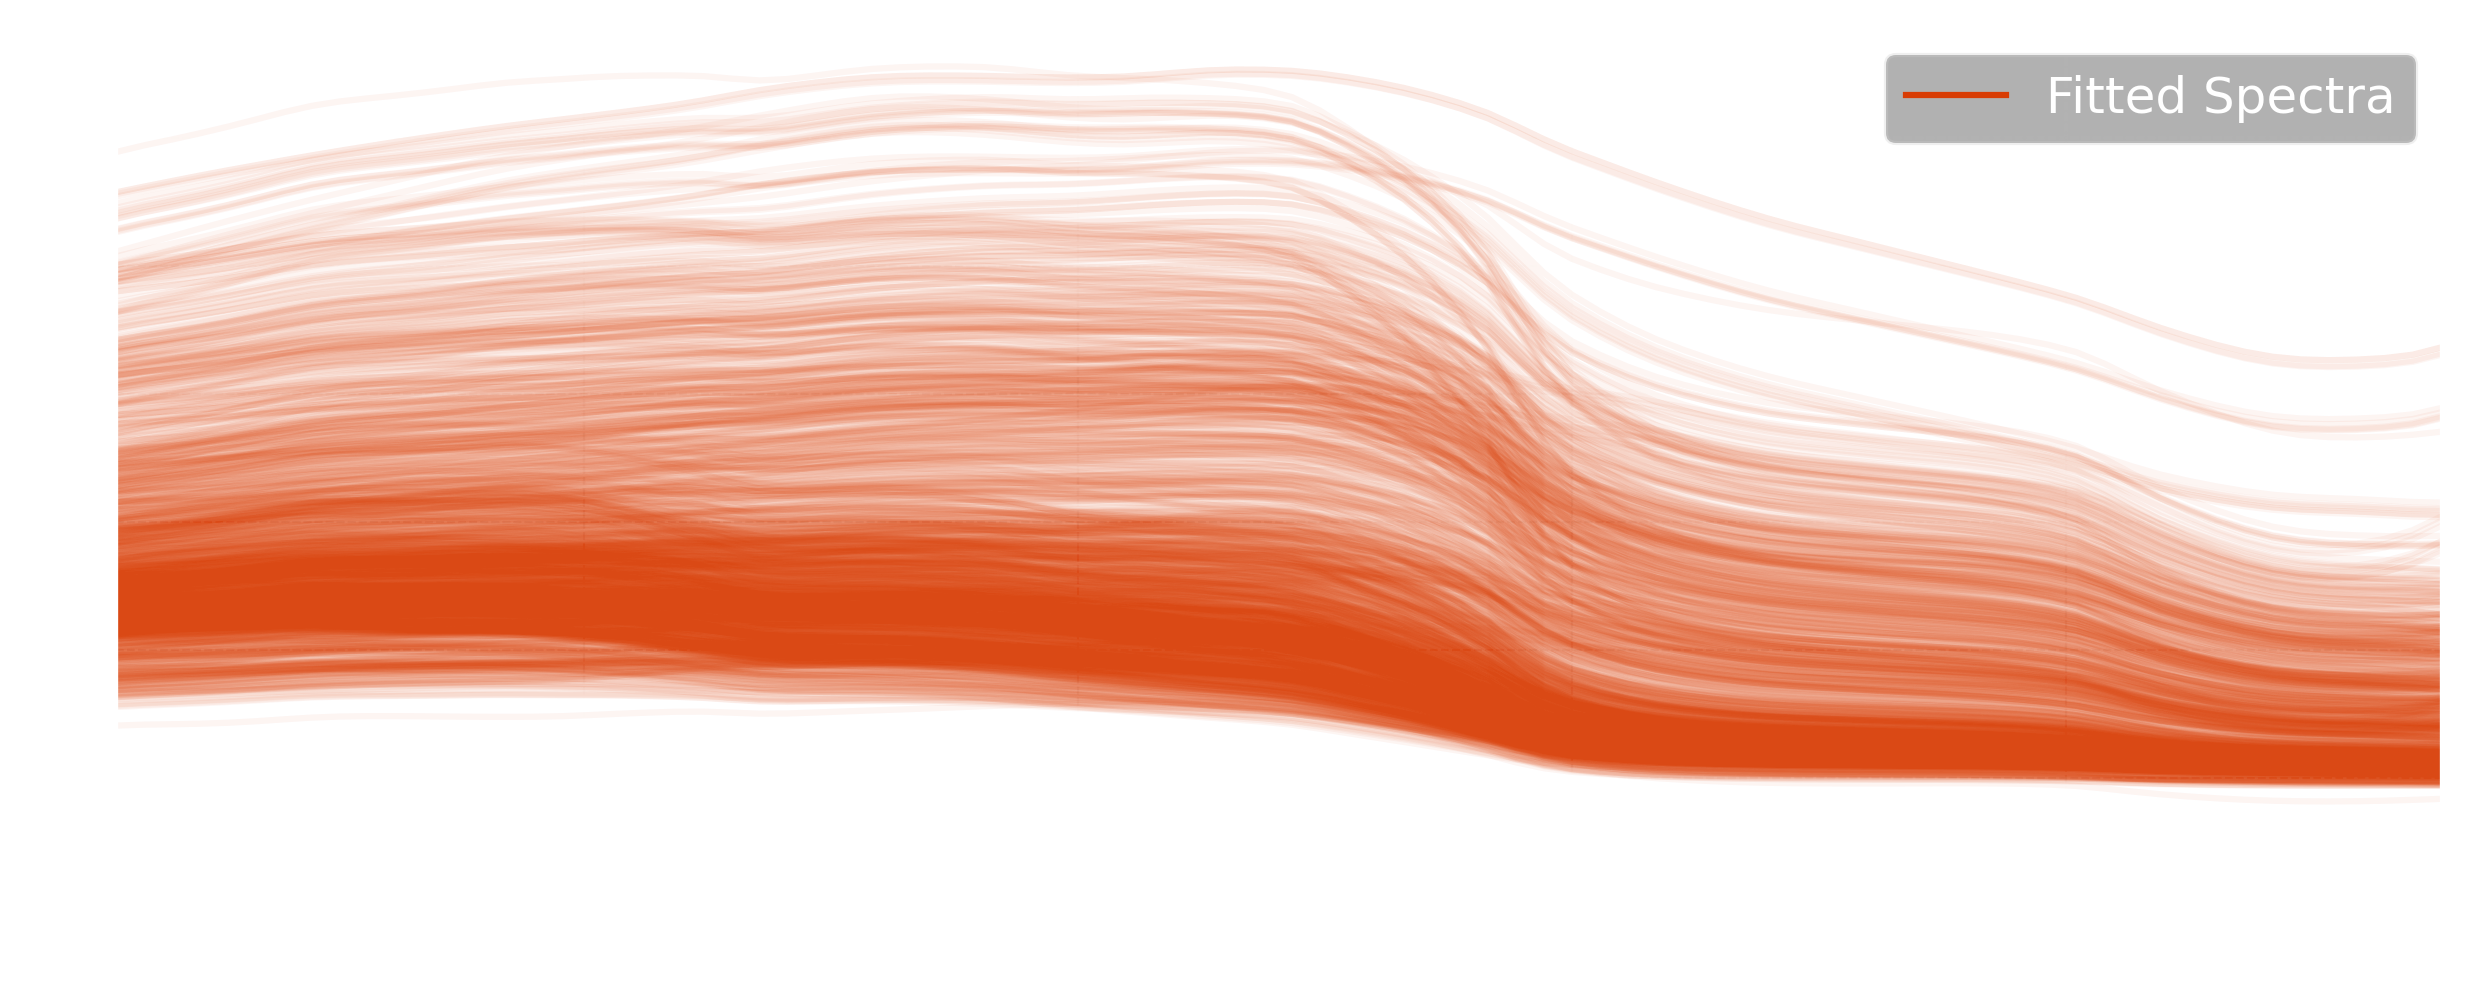

In [75]:
fit_results = pd.read_csv(file_ops.RESULTS_DIR_FP / "fits" / "fit_results_1.csv", header=[0,1])
fitted_spectra = fit_results.fitted_spectra
fitted_spectra.columns = fitted_spectra.columns.astype(float)

fig, ax = plt.subplots(1, 1, figsize=(10, 3.5), dpi=300)
fig.patch.set_alpha(0)
ax.patch.set_alpha(0)
ax.plot(fitted_spectra.T, alpha=0.05, c="#d83c04")
ax.grid(True, color='white', ls='--', linewidth=0.5, alpha=0.5, which='both')
ax.set_xlim(min(fitted_spectra.columns), max(fitted_spectra.columns))
ax.set_xlabel("Wavelength (nm)", color="white")
ax.set_ylabel("Reflectance", color="white")
ax.set_yticklabels([])
plotting.format_axis_for_ppt(ax)
ax.plot([], [], label="Fitted Spectra", color="#d83c04", alpha=1)
ax.legend(facecolor='black', framealpha=0.3, labelcolor="white", fontsize=12)
# ax.text(
#     0.98,
#     0.9,
#     "Fitted Spectra",
#     horizontalalignment="right",
#     verticalalignment="center",
#     transform=ax.transAxes,
#     color="white",
#     fontsize=12,
# )

In [95]:
no_nan_hs_vals[::100].T

1631      2472      2572      3328      3428      4139    \
452.642761  0.033974  0.036991  0.035379  0.036621  0.037363  0.021563   
455.475067  0.034218  0.037574  0.036126  0.036338  0.037337  0.022005   
458.307404  0.034101  0.038010  0.035645  0.037043  0.037748  0.022432   
461.139801  0.034888  0.038014  0.036373  0.037486  0.038123  0.023137   
463.972229  0.035233  0.038210  0.036715  0.037813  0.038395  0.023659   
...              ...       ...       ...       ...       ...       ...   
676.566284  0.003679  0.006149  0.007492  0.006210  0.006156  0.003837   
679.403015  0.003672  0.006435  0.007687  0.006158  0.006231  0.004067   
682.239807  0.003651  0.005980  0.007851  0.006039  0.006249  0.004043   
685.076599  0.003740  0.006062  0.008249  0.006149  0.006243  0.004061   
687.913513  0.004191  0.007169  0.008563  0.006680  0.006950  0.004760   

              4239      4869      4969      5069    ...    895311    895933  \
452.642761  0.047653  0.020162  0.110587  0.097607  ...  0.036027  0.051722   
455.475067  0.048258  0.020586  0.113323  0.099426  ...  0.036269  0.053074   
458.307404  0.048669  0.021029  0.115425  0.100512  ...  0.036539  0.053959   
461.139801  0.049925  0.021701  0.118200  0.102628  ...  0.037277  0.054729   
463.972229  0.050613  0.022445  0.120610  0.104054  ...  0.036842  0.055798   
...              ...       ...       ...       ...  ...       ...       ...   
676.566284  0.005391  0.001991  0.108336  0.086032  ...  0.002879  0.018970   
679.403015  0.005487  0.002249  0.108425  0.086537  ...  0.002741  0.018757   
682.239807  0.005414  0.002093  0.109094  0.087614  ...  0.002657  0.018516   
685.076599  0.005350  0.002242  0.110093  0.088941  ...  0.002839  0.018421   
687.913513  0.005734  0.002390  0.111496  0.091422  ...  0.003421  0.018729   

              896033    896133    896785    896885    896985    897700  \
452.642761  0.044924  0.041582  0.046501  0.047798  0.041184  0.051725   
455.475067  0.045836  0.042108  0.047006  0.048433  0.041781  0.052219   
458.307404  0.046044  0.042568  0.047765  0.048933  0.042501  0.053243   
461.139801  0.046998  0.042988  0.048419  0.049423  0.042942  0.053964   
463.972229  0.046943  0.043659  0.049122  0.050208  0.043206  0.054538   
...              ...       ...       ...       ...       ...       ...   
676.566284  0.009766  0.003299  0.018625  0.011384  0.003838  0.011276   
679.403015  0.009737  0.003370  0.018509  0.011023  0.003902  0.011228   
682.239807  0.009502  0.003215  0.018391  0.011026  0.003826  0.010966   
685.076599  0.009695  0.003315  0.018834  0.011032  0.003755  0.011043   
687.913513  0.010169  0.003927  0.019488  0.011695  0.004247  0.011458   

              898483    898583  
452.642761  0.041184  0.048956  
455.475067  0.042288  0.049279  
458.307404  0.043926  0.050026  
461.139801  0.045095  0.050743  
463.972229  0.045847  0.051272  
...              ...       ...  
676.566284  0.051012  0.009861  
679.403015  0.051435  0.009985  
682.239807  0.052135  0.009839  
685.076599  0.053564  0.009666  
687.913513  0.055857  0.010039  

[84 rows x 6867 columns]

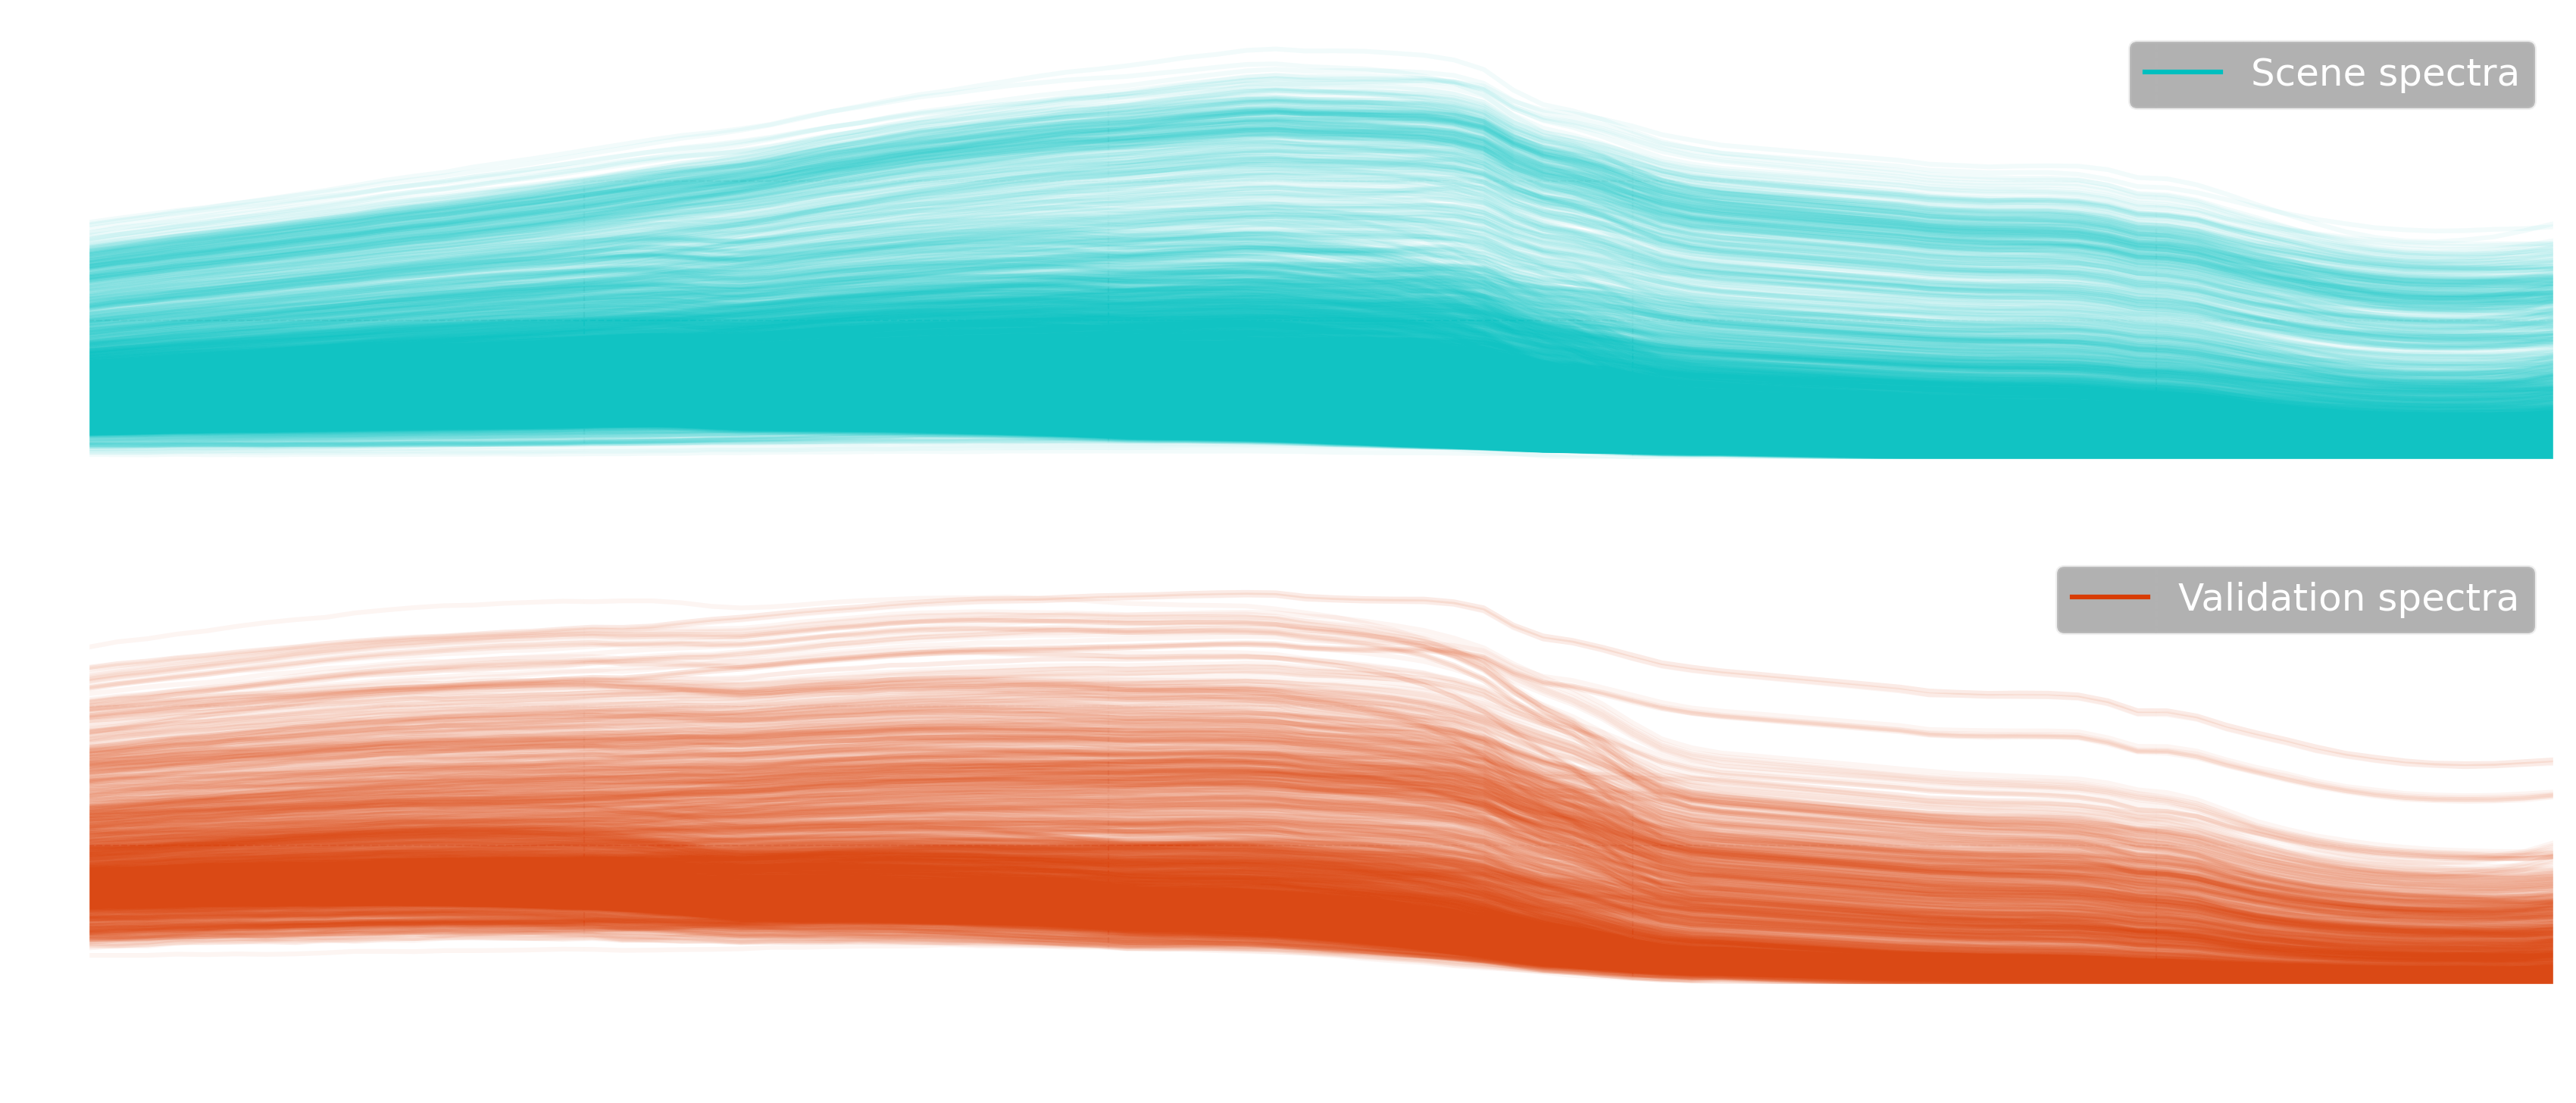

In [102]:
import xarray as xa
# visualise difference between validation and fitted spectra
scene_xa = xa.open_dataset(file_ops.KANEOHE_HS_FP).site
masked_scene_vals = scene_xa.values.reshape(scene_xa.sizes["band"], -1)

wvs = scene_xa.band.values
hs_vals = pd.DataFrame(masked_scene_vals.T, columns=wvs)
# process: deglint and crop to sensor range
hs_vals = spectrum_utils.deglint_spectra(hs_vals)
hs_vals = spectrum_utils.crop_spectra_to_range(hs_vals)
no_nan_hs_vals = hs_vals.dropna()

fig, ax = plt.subplots(2, 1, figsize=(14, 5.5), dpi=300, sharex=True)
fig.patch.set_alpha(0)

ax[0].plot(no_nan_hs_vals[::100].T, alpha=0.05, c="c")
ax[0].plot([], [], label="Scene spectra", color="c", alpha=1)
ax[1].plot([], [], label="Validation spectra", color="#d83c04", alpha=1)
ax[1].plot(prism_spectra.T, alpha=0.05, c="#d83c04")
ax[0].legend(facecolor='black', framealpha=0.3, labelcolor="white", fontsize=12)
ax[1].legend(facecolor='black', framealpha=0.3, labelcolor="white", fontsize=12)
ax[1].set_xlabel("Wavelength (nm)", color="white")

for a in ax:
    a.patch.set_alpha(0)
    a.grid(True, color='white', ls='--', linewidth=0.5, alpha=0.5, which='both')
    a.set_xlim(min(hs_vals.columns), max(hs_vals.columns))
    a.set_ylabel("Reflectance", color="white")
    a.set_yticklabels([])
    a.set_ylim(0, np.max(no_nan_hs_vals));
    plotting.format_axis_for_ppt(a)

# Deep or Reef?

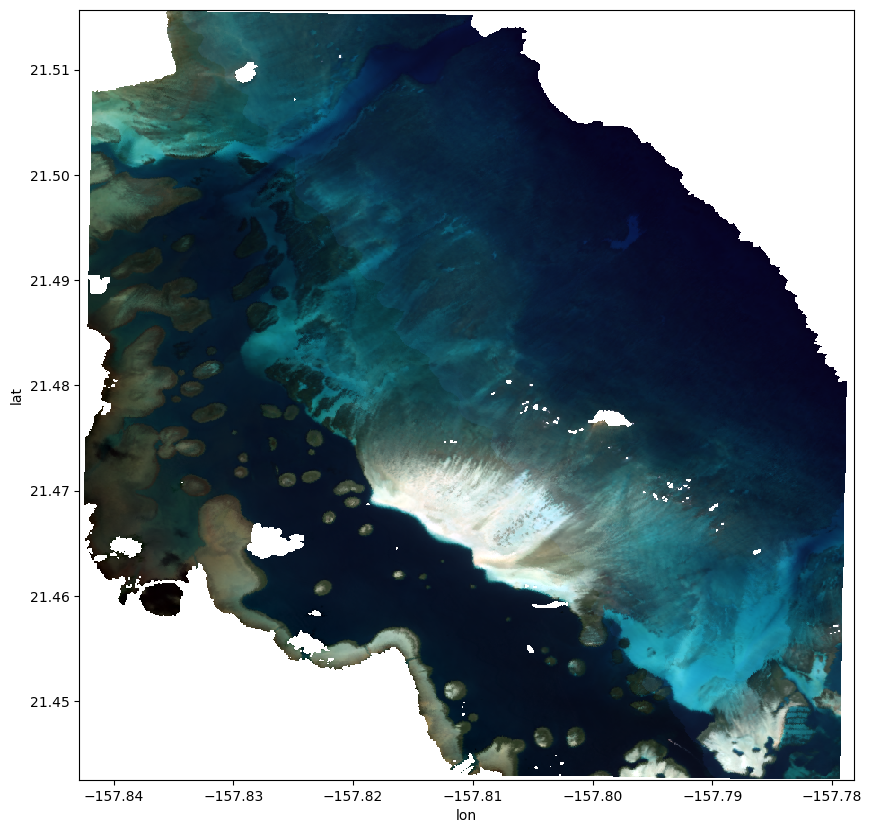

In [345]:
import xarray as xa
from reflectance import ml_utils
kaneohe_xa = xa.open_dataset(file_ops.KANEOHE_HS_FP)
# visualise rgb

hs_vals = ml_utils.spectral_xa_to_processed_spectral_df(kaneohe_xa["site"])
# plot, taking band values as RGB values
vis_percentiles=(0.1, 99.9)
rgb_vals = plotting.generate_and_visualise_spectral_colours(hs_vals, vis_percentiles=vis_percentiles)

# reform rgb_vals back to kaneohe_xa dataset
rgb_xa = xa.DataArray(rgb_vals.reshape(len(kaneohe_xa.lat), len(kaneohe_xa.lon), -1), dims=("lat", "lon", "rgb"), coords={"lat": kaneohe_xa.lat, "lon": kaneohe_xa.lon, "rgb": ["r", "g", "b"]})
rgb_xa.plot.imshow(rgb="rgb", figsize=(10, 10), robust=False);


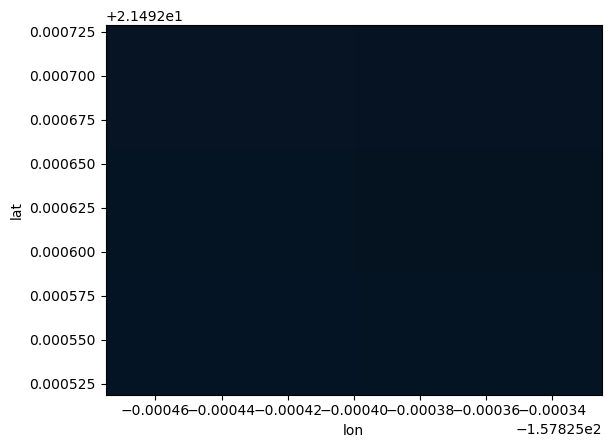

In [447]:
deep_lats = (21.48, 21.485)
deep_lons = (-157.79, -157.785)

reef_lats = (21.49, 21.496)
reef_lons = (-157.829, -157.82)
reef_lats = (21.4925, 21.4927)
reef_lons = (-157.8255, -157.8253)
rgb_xa.sel(lat=slice(*reef_lats), lon=slice(*reef_lons)).plot.imshow()

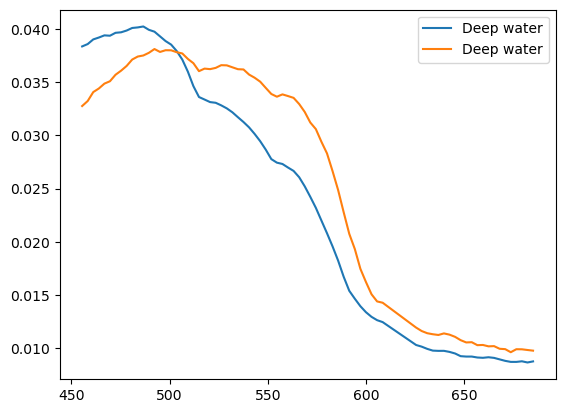

In [486]:
deep_spectrum = kaneohe_xa.sel(lat=slice(*deep_lats), lon=slice(*deep_lons)).mean(dim=["lat", "lon"]).site.values
reef_spectrum = kaneohe_xa.sel(lat=slice(*reef_lats), lon=slice(*reef_lons)).mean(dim=["lat", "lon"]).site.values
# crop to sensnor range
lim_wv_inds = (wvs >= min(prism_spectra.columns)) & (wvs <= max(prism_spectra.columns))
lim_wvs = wvs[lim_wv_inds]

plt.plot(lim_wvs, deep_spectrum[lim_wv_inds], label="Deep water")
plt.plot(lim_wvs, reef_spectrum[lim_wv_inds], label="Deep water")
plt.legend()

(0.005, 0.045)

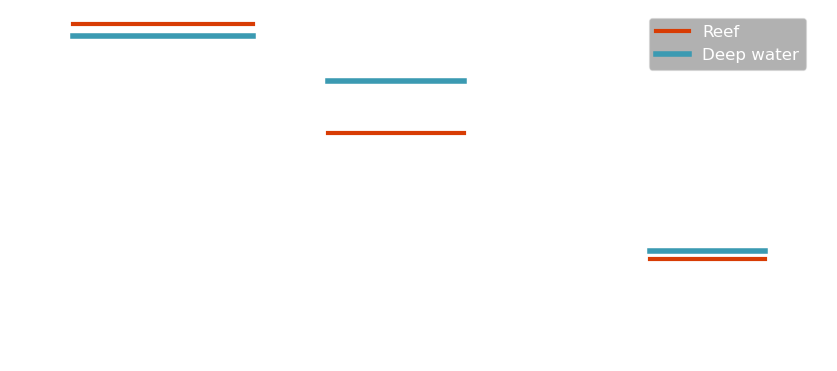

In [514]:
spectra_comp_df = pd.DataFrame(
    {
        "Deep water": deep_spectrum[lim_wv_inds],
        "Reef": reef_spectrum[lim_wv_inds],
    },
    index=lim_wvs,
).T
interped_lim = spectrum_utils.interp_df(spectra_comp_df)

# visualise with planet bands
comp_planet_band_vals_df = spectrum_utils.calculate_band_values(planet_response_fns, bois=["Blue", "Green", "Red", "NIR"], interped_prism=interped_lim)
comp_planet_continuous_response_df = interped_lim.loc[:, comp_planet_band_vals_df.index] * comp_planet_band_vals_df
comp_planet_mean_response_df = comp_planet_continuous_response_df.mean(axis=0, skipna=True)
comp_planet_flattened_mean_response_df = spectrum_utils.fill_clumps_with_mean(comp_planet_continuous_response_df)

fig, ax = plt.subplots(figsize=(10, 4))
ax.patch.set_alpha(0)
fig.patch.set_alpha(0)
# ax.plot(comp_planet_flattened_mean_response_df.T, lw=2, alpha=1)
ax.plot(comp_planet_flattened_mean_response_df.T.iloc[:, 0], color='#d83c04', lw=3, alpha=1, label='Reef')
ax.plot(comp_planet_flattened_mean_response_df.T.iloc[:, 1], color='#3B9AB2', lw=4, alpha=1, label='Deep water')
ax.set_ylabel("Reflectance", color="white")
ax.legend(facecolor='black', framealpha=0.3, labelcolor="white", fontsize=12)
ax.set_xlabel("Wavelength (nm)", color="white")
plotting.format_axis_for_ppt(ax)
# ax.set_xlim(min(lim_wvs), max(lim_wvs))

# ax.set_xticks(new_ax.get_xticks())
ax.set_xlim(450, 700)
ax.set_yticklabels([]);
new_ax.set_ylim(0.005, 0.045)

(0.005, 0.045)

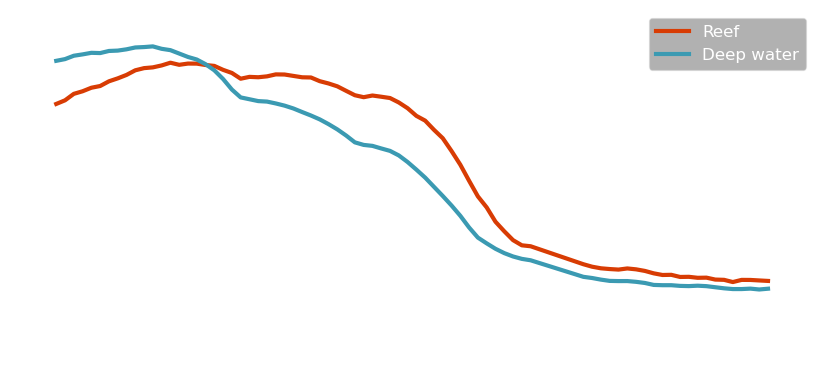

In [513]:
fig, new_ax = plt.subplots(figsize=(10, 4))
new_ax.patch.set_alpha(0)
fig.patch.set_alpha(0)
# new_ax.plot(comp_planet_flattened_mean_response_df.T, lw=2, alpha=1)
new_ax.plot(lim_wvs, reef_spectrum[lim_wv_inds], label="Reef", color="#d83c04", lw=3)
new_ax.plot(lim_wvs, deep_spectrum[lim_wv_inds], label="Deep water", color="#3B9AB2", lw=3)
new_ax.set_ylabel("Reflectance", color="white")
new_ax.legend(facecolor='black', framealpha=0.3, labelcolor="white", fontsize=12)
new_ax.set_xlabel("Wavelength (nm)", color="white")
plotting.format_axis_for_ppt(new_ax)
new_ax.set_yticklabels([])
# new_ax.set_xticks(np.arange(450, 701, 50));
new_ax.set_xlim(450, 700)
new_ax.set_ylim(0.005, 0.045)

Text(0.5, 0, 'Wavelength (nm)')

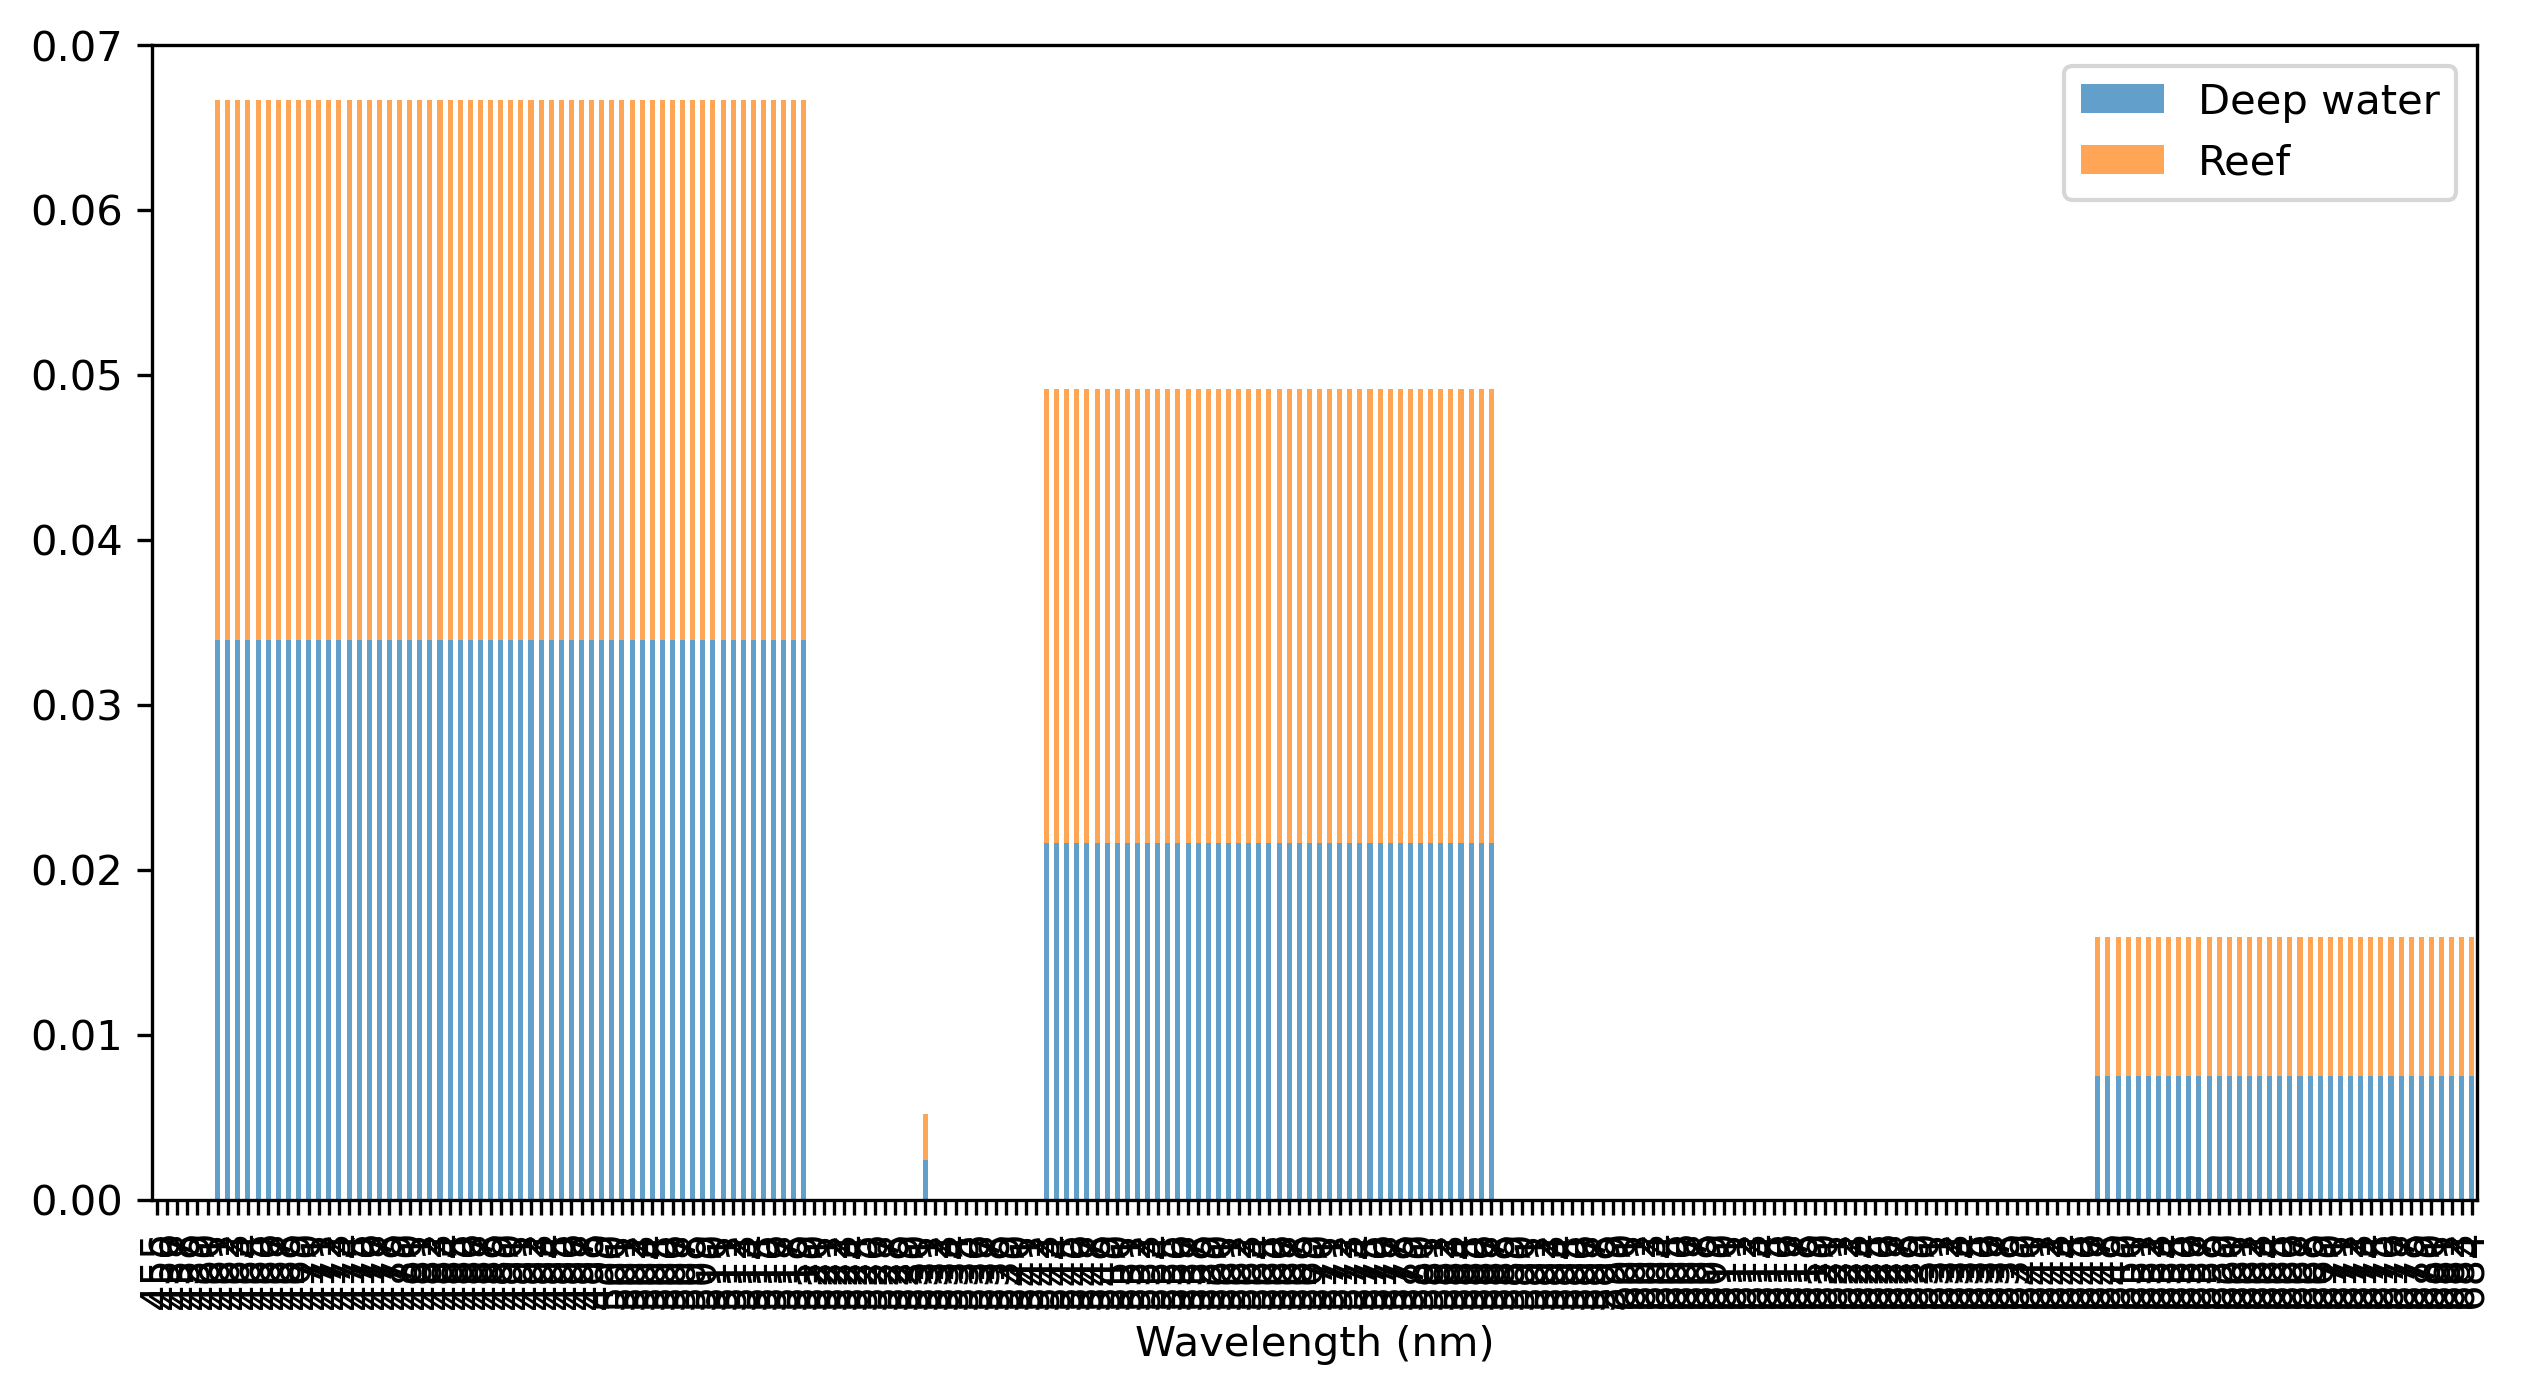

In [450]:
# plot comp_planet_flatted_mean_response_df as a bar chart with adjacent bars
fig, ax = plt.subplots(1, 1, figsize=(10, 5), dpi=300)
comp_planet_flattened_mean_response_df.T.plot(kind="bar", ax=ax, stacked=True, alpha=0.7)
ax.set_xlabel("Wavelength (nm)")

In [267]:
# read in spectral library
f = file_ops.RESOURCES_DIR_FP / "spectral_library_clean_v3_PRISM_wavebands.csv"
df = pd.read_csv(f, skiprows=1).set_index('wavelength')
df.columns = df.columns.astype(float)
df = df.astype(float)
wvs = df.columns[(df.columns > spectrum_utils.SENSOR_RANGE[0]) & (df.columns < spectrum_utils.SENSOR_RANGE[1])]


three_em_cats = {
    'algae': ['algae_fleshy_brown', 'algae_fleshy_green', 'algae_fleshy_red', 'algae_turf', 'seagrass', 'algae_crustose_coralline'],
    'coral': ['coral_blue', 'coral_brown', 'octocoral'],
    'sand': ['sand', 'mud']
}

three_endmembers = {}
for cat in three_em_cats:
    ind = df.index.isin(three_em_cats[cat])
    # select all spectra in category and calculate mean spectrum
    three_endmembers[cat] = df.loc[ind].mean(axis=0).loc[wvs]
# create array of average spectrum for each category
three_endmember_array = np.array([spectrum.values for spectrum in three_endmembers.values()])


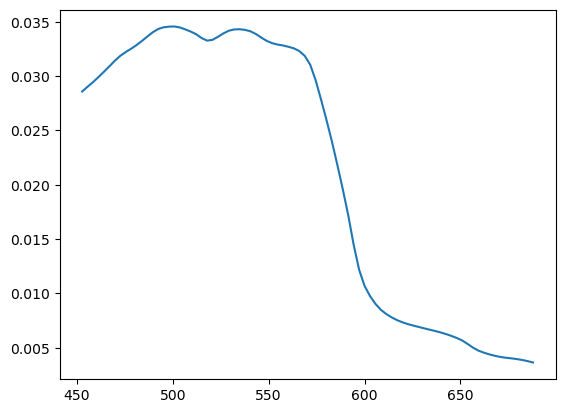

In [320]:
endmember_array = three_endmember_array
short_AOP_args = spectrum_utils.process_aop_model(AOP_model)
# representative water AOPs
bb = 0.02
K = 0.5

Rb = (0,0,1)
depth = 10

sim = spectrum_utils.sub_surface_reflectance_Rb(wvs, endmember_array, bb, K, depth, short_AOP_args, *Rb)

plt.plot(wvs, sim)


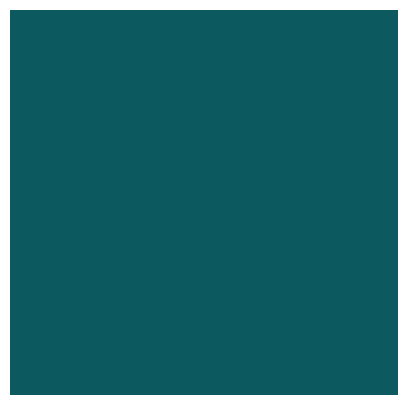

In [319]:
sim_df = pd.DataFrame(sim.T, index=wvs).T
test_df = pd.concat([sim_df, sim_df], axis=0)
color = plotting.generate_spectra_color(test_df, wvs = wvs)
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.add_patch(plt.Rectangle((0, 0), 1, 1, color=color[0,:]*10))
ax.axis("off")
plt.show()


In [252]:
# simulate a few deep spectra
deep_spectrum = 

# simulate a few high-coral spectra